In [1]:
import numpy as np
import h5py
import glob, os, re, sys

from scipy.signal import savgol_filter as sg
from scipy.stats import gaussian_kde
from scipy import interpolate

import density_contours

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import cm
from matplotlib import ticker
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.patches as patches
import matplotlib.font_manager as fm
fontprops = fm.FontProperties(size=20)
import matplotlib.colors as mplcolors
from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D

In [2]:
# Plotting properties
grey = '#3C3C3C'
from matplotlib import rc
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['xtick.major.pad'] = 5
mpl.rcParams['ytick.major.pad'] = 5
mpl.rcParams['axes.labelpad'] = 10
mpl.rcParams['font.size'] = 20
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['legend.numpoints'] = 1
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['mathtext.default'] = 'regular'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['xtick.color'] = grey
mpl.rcParams['ytick.color'] = grey
mpl.rcParams['axes.edgecolor'] = grey
mpl.rcParams['axes.labelcolor'] = grey
rc('axes', linewidth=1.5)
rc('axes', edgecolor=grey)
labels_font = {'size':'20'} 

In [3]:
Msol_to_g = 1.99E33
Myr_to_s = 3.16E13
Gyr_to_s = 3.16E16
yr_to_s = 3.16E7
pc_to_cm = 3.086E18
kpc_to_cm = 3.086E21
kms_to_cms = 1.E5
G_cgs = 6.67E-8
kB_cgs = 1.38E-16
gamma = 5./3.
mu = 1.4
mp_cgs = 1.67e-24

In [4]:
def flatten_list(lst):
    if type(lst[0])==list:
        return [item for sublist in lst for item in sublist]
    else:
        return lst

# pressures, weights, SFRs as a function of galactocentric radius (ETGs)

In [5]:
# snapshot to analyse
Rmin, Rmax = 0.3, 1.5
folders = ['ETGs/vlM-output', 'ETGs/lowM-output', 'ETGs/medM-output', 'ETGs/hiM-output']
minno, maxno = 100, 400

In [6]:
Rmin, Rmax = 0.3, 1.5
Rbinno = int(np.rint((Rmax-Rmin)/(0.2)))
Rbin_edges = np.linspace(Rmin, Rmax, Rbinno+1) * kpc_to_cm
Rbin_centres = (Rbin_edges[1:]+Rbin_edges[:-1])/2.

phibinno = 8
phibin_edges = np.linspace(-np.pi, np.pi, phibinno+1)
phibin_centres = (phibin_edges[1:]+phibin_edges[:-1])/2.
areas = np.zeros((Rbinno, phibinno))
for i in range(phibinno):
    areas[:,i] = np.pi*(Rbin_edges[1:]**2-Rbin_edges[:-1]**2)/phibinno

zbinno = 60
zbin_edges = np.linspace(-300., 300., zbinno+1) * pc_to_cm # 100-pc slices
zbin_centres = (zbin_edges[1:]+zbin_edges[:-1])/2.
deltaz = 600.*pc_to_cm/zbinno

R_grid, phi_grid, z_grid = np.meshgrid(Rbin_centres, phibin_centres, zbin_centres)

In [7]:
# load arrays
medSigmaSFRs, q1SigmaSFRs, q4SigmaSFRs = [], [], []
medPturbs, q1Pturbs, q4Pturbs = [], [], []
medPths, q1Pths, q4Pths = [], [], []
medPtots, q1Ptots, q4Ptots = [], [], []
medargmaxPs, q1argmaxPs, q4argmaxPs = [], [], []
Ptotmeans, SigmaSFRmeans = [], []
for folder in folders:
    SigmaSFRs = np.zeros((Rbinno, phibinno, maxno-minno))
    Pturbs = np.zeros((Rbinno, phibinno, maxno-minno))
    Pths = np.zeros((Rbinno, phibinno, maxno-minno))
    argmaxPs = np.zeros((Rbinno, phibinno, maxno-minno))
    Ptotmeans_, SigmaSFRmeans_ = [], []
    for no in range(minno, maxno):
        SigmaSFRs[:,:,no-minno] = np.load(
            "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+
            "/saved-arrays/SigmaSFR-0.5kpc_"+str(no)+".npy",
            allow_pickle=True
        )/Msol_to_g/1.e6*kpc_to_cm**2 # original in g/cm^2/Myr
        Pturbs[:,:,no-minno] = np.load(
            "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+
            "/saved-arrays/rotcurve-data-avir-0.5kpc-Pturbs_"+str(no)+".npy",
            allow_pickle=True
        )
        Pths[:,:,no-minno] = np.load(
            "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+
            "/saved-arrays/rotcurve-data-avir-0.5kpc-Pths_"+str(no)+".npy",
            allow_pickle=True
        )
        argmaxPs[:,:,no-minno] = np.load(
            "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+
            "/saved-arrays/rotcurve-data-avir-0.5kpc-argmaxP_"+str(no)+".npy",
            allow_pickle=True
        )
        Ptotmeans_.append(np.sum((Pturbs[:,:,no-minno]+Pths[:,:,no-minno])*areas)/np.sum(areas))
        SigmaSFRmeans_.append(np.sum(SigmaSFRs[:,:,no-minno]*areas)/np.sum(areas))
    
    # take median over the time and phi axes simultaneously
    #SigmaSFRs[SigmaSFRs==0.] = 1e-10
    meanSigmaSFRs = np.mean(SigmaSFRs, axis=1)
    #medSigmaSFRs.append(np.mean(SigmaSFRs, axis=(1,2)))
    #medSigmaSFRs.append(np.nanmedian(SigmaSFRs, axis=(1,2)))
    medSigmaSFRs.append(np.nanmedian(meanSigmaSFRs, axis=1))
    q1SigmaSFRs.append(np.nanpercentile(meanSigmaSFRs, 25, axis=1))
    q4SigmaSFRs.append(np.nanpercentile(meanSigmaSFRs, 75, axis=1))
    
    medPturbs.append(np.median(Pturbs, axis=(1,2)))
    q1Pturbs.append(np.percentile(Pturbs, 25, axis=(1,2)))
    q4Pturbs.append(np.percentile(Pturbs, 75, axis=(1,2)))

    medPths.append(np.median(Pths, axis=(1,2)))
    q1Pths.append(np.percentile(Pths, 25, axis=(1,2)))
    q4Pths.append(np.percentile(Pths, 75, axis=(1,2)))
    
    medPtots.append(np.median(Pths+Pturbs, axis=(1,2)))
    q1Ptots.append(np.percentile(Pths+Pturbs, 25, axis=(1,2)))
    q4Ptots.append(np.percentile(Pths+Pturbs, 75, axis=(1,2)))
    
    medargmaxPs.append(np.median(argmaxPs, axis=(1,2)))
    q1argmaxPs.append(np.percentile(argmaxPs, 25, axis=(1,2)))
    q4argmaxPs.append(np.percentile(argmaxPs, 75, axis=(1,2)))
    
    Ptotmeans.append(Ptotmeans_)
    SigmaSFRmeans.append(SigmaSFRmeans_)

medUpsilons = [1.e5*medPtots_**(-0.235)*10.**4.2 for medPtots_ in medPtots]
medUpsilonSigmaSFRs = [medPtots_*kB_cgs/medUpsilons_/Msol_to_g*kpc_to_cm**2*yr_to_s for medPtots_, medUpsilons_ in zip(medPtots, medUpsilons)]
q1UpsilonSigmaSFRs = [q1Ptots_*kB_cgs/medUpsilons_/Msol_to_g*kpc_to_cm**2*yr_to_s for q1Ptots_, medUpsilons_ in zip(q1Ptots, medUpsilons)]
q4UpsilonSigmaSFRs = [q4Ptots_*kB_cgs/medUpsilons_/Msol_to_g*kpc_to_cm**2*yr_to_s for q4Ptots_, medUpsilons_ in zip(q4Ptots, medUpsilons)]
Ptotmeans = np.array(Ptotmeans)
SigmaSFRmeans = np.array(SigmaSFRmeans)

/tmp/ipykernel_4126933/3633527813.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot(Rbin_centres/kpc_to_cm, np.log10(medSigmaSFRs_))


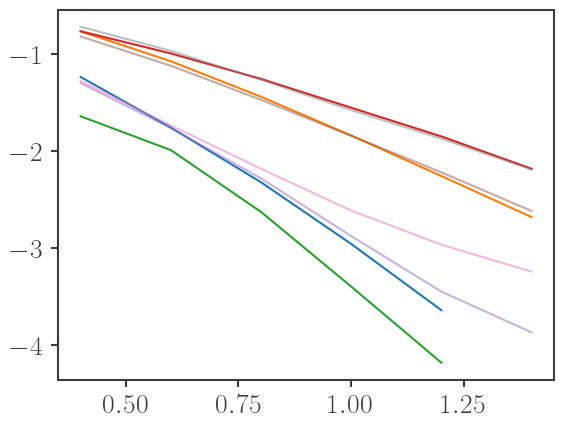

In [8]:
for medSigmaSFRs_ in medSigmaSFRs:
    plt.plot(Rbin_centres/kpc_to_cm, np.log10(medSigmaSFRs_))
for medUpsilonSigmaSFRs_ in medUpsilonSigmaSFRs:
    plt.plot(Rbin_centres/kpc_to_cm, np.log10(medUpsilonSigmaSFRs_), alpha=0.5)
plt.show()

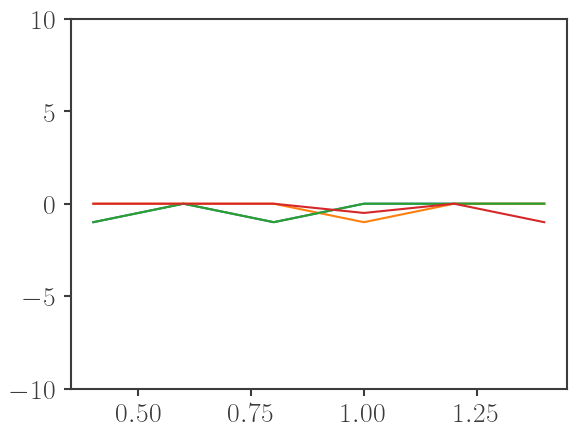

In [9]:
for medargmaxPs_ in medargmaxPs:
    plt.plot(Rbin_centres/kpc_to_cm, medargmaxPs_-30)
plt.ylim([-10, 10])
plt.show()

In [10]:
medweights, q1weights, q4weights = [], [], []
medweight0s, q1weight0s, q4weight0s = [], [], []
medweight1s, q1weight1s, q4weight1s = [], [], []
medweight2s, q1weight2s, q4weight2s = [], [], []
medweight3s, q1weight3s, q4weight3s = [], [], []
weightmeans = []
for folder in folders:
    ptls = sorted(glob.glob(os.path.join(
        "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+"/saved-arrays/ptl_*.npy")))
    ptlnos = [ptl.rsplit('ptl_')[1].rsplit('.npy')[0] for ptl in ptls]
    
    weight = np.zeros((phibinno, Rbinno, len(ptlnos)))
    weight0 = np.zeros((phibinno, Rbinno, len(ptlnos)))
    weight1 = np.zeros((phibinno, Rbinno, len(ptlnos)))
    weight2 = np.zeros((phibinno, Rbinno, len(ptlnos)))
    weight3 = np.zeros((phibinno, Rbinno, len(ptlnos)))
    weightmeans_ = []
    for ptlno, i in zip(ptlnos, range(len(ptlnos))):
        ptl = np.load(
            "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+
            "/saved-arrays/ptl_"+str(ptlno)+".npy",
            allow_pickle=True
        )
        ptl1 = np.load(
            "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+
            "/saved-arrays/ptl1_"+str(ptlno)+".npy",
            allow_pickle=True
        )
        ptl2 = np.load(
            "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+
            "/saved-arrays/ptl2_"+str(ptlno)+".npy",
            allow_pickle=True
        )
        ptl3 = np.load(
            "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+
            "/saved-arrays/ptl3_"+str(ptlno)+".npy",
            allow_pickle=True
        )
        #ptl4 = ptl2 * 0.2
        rho3D = np.load(
            "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+
            "/saved-arrays/rotcurve-data-avir-rho3Ds"+str(ptlno)+".npy",
            allow_pickle=True
        )
        rho3D = np.swapaxes(rho3D, 0,1)

        # weights
        polyno = 2
        wndwlen = 9

        dz = sg(z_grid, wndwlen, polyno, deriv=1, axis=2)
        dPhi = sg(ptl, wndwlen, polyno, deriv=1, axis=2)
        dPhidz = dPhi/dz
        weight0[:,:,i] = np.sum(np.fabs(rho3D*dPhidz*deltaz)/2., axis=2)

        dPhi1 = sg(ptl1, wndwlen, polyno, deriv=1, axis=2)
        dPhi1dz = dPhi1/dz
        weight1[:,:,i] = np.sum(np.fabs(rho3D*dPhi1dz*deltaz)/2., axis=2)

        dPhi2 = sg(ptl2, wndwlen, polyno, deriv=1, axis=2)
        dPhi2dz = dPhi2/dz
        weight2[:,:,i] = np.sum(np.fabs(rho3D*dPhi2dz*deltaz)/2., axis=2)

        dPhi3 = sg(ptl3, wndwlen, polyno, deriv=1, axis=2)
        dPhi3dz = dPhi3/dz
        weight3[:,:,i] = np.sum(np.fabs(rho3D*dPhi3dz*deltaz)/2., axis=2)

        dPhitotdz = dPhidz + dPhi1dz + dPhi2dz + dPhi3dz# + dPhi4dz
        weight[:,:,i] = np.sum(np.fabs(rho3D*dPhitotdz*deltaz)/2., axis=2)
        weightmeans_.append(np.average(weight[:,:,i]))#, weights=R_grid[:,:,0]))
                
    medweights.append(np.median(weight, axis=(0,2)))
    q1weights.append(np.percentile(weight, 25, axis=(0,2)))
    q4weights.append(np.percentile(weight, 75, axis=(0,2)))

    medweight0s.append(np.median(weight0, axis=(0,2)))
    q1weight0s.append(np.percentile(weight0, 25, axis=(0,2)))
    q4weight0s.append(np.percentile(weight0, 75, axis=(0,2)))
    
    medweight1s.append(np.median(weight1, axis=(0,2)))
    q1weight1s.append(np.percentile(weight1, 25, axis=(0,2)))
    q4weight1s.append(np.percentile(weight1, 75, axis=(0,2)))
    
    medweight2s.append(np.median(weight2, axis=(0,2)))
    q1weight2s.append(np.percentile(weight2, 25, axis=(0,2)))
    q4weight2s.append(np.percentile(weight2, 75, axis=(0,2)))
    
    medweight3s.append(np.median(weight3, axis=(0,2)))
    q1weight3s.append(np.percentile(weight3, 25, axis=(0,2)))
    q4weight3s.append(np.percentile(weight3, 75, axis=(0,2)))
                           
    weightmeans.append(weightmeans_)

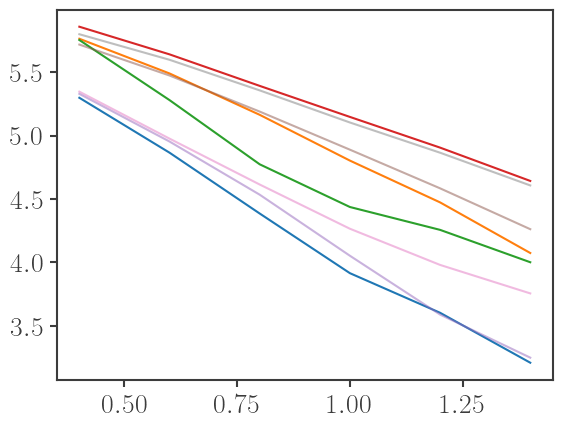

In [11]:
for medweights_ in medweights:
    plt.plot(Rbin_centres/kpc_to_cm, np.log10(medweights_/kB_cgs))
for medPtots_, medPths_ in zip(medPtots, medPths):
    plt.plot(Rbin_centres/kpc_to_cm, np.log10(medPtots_), alpha=0.5)
plt.show()

In [12]:
medSigmag, q1Sigmag, q4Sigmag = [], [], []
for folder in folders:
    Sigmag = np.zeros((Rbinno, phibinno, maxno-minno))
    for no in range(minno, maxno):
        Sigmag[:,:,no-minno] = np.load(
            "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+
            "/saved-arrays/RomeoQ-data-Sigmag-0.5kpc_"+str(no)+".npy",
            allow_pickle=True
        )
    
    # take median over the time and phi axes simultaneously
    medSigmag.append(np.median(Sigmag, axis=(1,2)))
    q1Sigmag.append(np.percentile(Sigmag, 25, axis=(1,2)))
    q4Sigmag.append(np.percentile(Sigmag, 75, axis=(1,2)))

In [13]:
medSigmaH2, q1SigmaH2, q4SigmaH2 = [], [], []
medSigmaSFRsH2, q1SigmaSFRsH2, q4SigmaSFRsH2 = [], [], []
for folder in folders:
    SigmaH2 = np.zeros((Rbinno, phibinno, maxno-minno))
    SigmaSFRs = np.zeros((Rbinno, phibinno, maxno-minno))
    for no in range(minno, maxno):
        SigmaH2[:,:,no-minno] = np.load(
            "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+
            "/saved-arrays/SigmaH2-0.5kpc_"+str(no)+".npy",
            allow_pickle=True
        )
        SigmaSFRs[:,:,no-minno] = np.load(
            "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+
            "/saved-arrays/SigmaSFR-0.5kpc_"+str(no)+".npy",
            allow_pickle=True
        )/Msol_to_g/1.e6*kpc_to_cm**2 # original in g/cm^2/Myr
    
    # take median over the time and phi axes simultaneously
    SigmaH2[SigmaH2/Msol_to_g*pc_to_cm**2.<=0.] = np.nan
    medSigmaH2.append(np.median(SigmaH2, axis=(1,2)))
    q1SigmaH2.append(np.percentile(SigmaH2, 25, axis=(1,2)))
    q4SigmaH2.append(np.percentile(SigmaH2, 75, axis=(1,2)))
    
    meanSigmaSFRs = np.nanmean(SigmaSFRs, axis=1)
    medSigmaSFRsH2.append(np.nanmedian(SigmaSFRs, axis=(1,2)))
    q1SigmaSFRsH2.append(np.nanpercentile(meanSigmaSFRs, 25, axis=1))
    q4SigmaSFRsH2.append(np.nanpercentile(meanSigmaSFRs, 75, axis=1))

# Milky Way

In [14]:
folders = ['MW-tracers']
MWRmin, MWRmax = 0.3, 13.
MWRbinno = int(np.rint((MWRmax-MWRmin)/(0.2)))
MWRbin_edges = np.linspace(MWRmin, MWRmax, MWRbinno+1) * kpc_to_cm
MWRbin_centres = (MWRbin_edges[1:]+MWRbin_edges[:-1])/2.

MWphibinno = 8
MWareas = np.zeros((MWRbinno, MWphibinno))
for i in range(MWphibinno):
    MWareas[:,i] = np.pi*(MWRbin_edges[1:]**2-MWRbin_edges[:-1]**2)/MWphibinno

zmin, zmax = -1500., 1500.
MWzbin_edges = np.linspace(zmin, zmax, zbinno+1) * pc_to_cm # 100-pc slices
MWzbin_centres = (MWzbin_edges[1:]+MWzbin_edges[:-1])/2.
MWdeltaz = (zmax-zmin)/zbinno*pc_to_cm

MWR_grid, MWphi_grid, MWz_grid = np.meshgrid(MWRbin_centres, phibin_centres, MWzbin_centres)

In [15]:
MWmedSigmaSFRs, MWq1SigmaSFRs, MWq4SigmaSFRs = [], [], []
MWmedPturbs, MWq1Pturbs, MWq4Pturbs = [], [], []
MWmedPths, MWq1Pths, MWq4Pths = [], [], []
MWmedPtots, MWq1Ptots, MWq4Ptots = [], [], []
MWPtotmeans, MWSigmaSFRmeans = [], []
for folder in folders:
    rcs = sorted(glob.glob(os.path.join(
        "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+"/saved-arrays/rotcurve-data-avir-0.5kpc-Pturbs-Tthresh_*.npy")))
    rcnos = [rc.rsplit('rotcurve-data-avir-0.5kpc-Pturbs-Tthresh_')[1].rsplit('.npy')[0] for rc in rcs]
    print(rcnos)
    
    SigmaSFRs = np.zeros((MWRbinno, MWphibinno, len(rcnos)))
    Pturbs = np.zeros((MWRbinno, MWphibinno, len(rcnos)))
    Pths = np.zeros((MWRbinno, MWphibinno, len(rcnos)))

    MWPtotmeans_, MWSigmaSFRmeans_ = [], []
    for no, i in zip(rcnos, range(len(rcnos))):
        SigmaSFRs[:,:,i] = np.load(
            "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+
            "/saved-arrays/SigmaSFR-0.5kpc_"+str(no)+".npy",
            allow_pickle=True
        )/Msol_to_g/1.e6*kpc_to_cm**2 # original in g/cm^2/Myr
        Pturbs[:,:,i] = np.load(
            "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+
            "/saved-arrays/rotcurve-data-avir-0.5kpc-Pturbs-Tthresh_"+str(no)+".npy",
            allow_pickle=True
        )/1.5
        Pths[:,:,i] = np.load(
            "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+
            "/saved-arrays/rotcurve-data-avir-0.5kpc-Pths-Tthresh_"+str(no)+".npy",
            allow_pickle=True
        )
        MWPtotmeans_.append(np.sum((Pturbs[:,:,i]+Pths[:,:,i])*MWareas)/np.sum(MWareas))
        MWSigmaSFRmeans_.append(np.sum(SigmaSFRs[:,:,i]*MWareas)/np.sum(MWareas))
    print(np.shape(SigmaSFRs[:,:,i]), np.shape(Pturbs[:,:,i]))
    
    # take median over the time and phi axes simultaneously
    #MWmedSigmaSFRs.append(np.mean(SigmaSFRs, axis=(1,2)))
    meanSigmaSFRs = np.mean(SigmaSFRs, axis=1)
    MWmedSigmaSFRs.append(np.median(meanSigmaSFRs, axis=1))
    #MWmedSigmaSFRs.append(np.median(SigmaSFRs, axis=(1,2)))
    MWq1SigmaSFRs.append(np.percentile(meanSigmaSFRs, 25, axis=1))
    MWq4SigmaSFRs.append(np.percentile(meanSigmaSFRs, 75, axis=1))
    
    MWmedPturbs.append(np.median(Pturbs, axis=(1,2)))
    MWq1Pturbs.append(np.percentile(Pturbs, 25, axis=(1,2)))
    MWq4Pturbs.append(np.percentile(Pturbs, 75, axis=(1,2)))

    MWmedPths.append(np.median(Pths, axis=(1,2)))
    MWq1Pths.append(np.percentile(Pths, 25, axis=(1,2)))
    MWq4Pths.append(np.percentile(Pths, 75, axis=(1,2)))
    
    MWmedPtots.append(np.median(Pths+Pturbs, axis=(1,2)))
    MWq1Ptots.append(np.percentile(Pths+Pturbs, 25, axis=(1,2)))
    MWq4Ptots.append(np.percentile(Pths+Pturbs, 75, axis=(1,2)))
    
    MWPtotmeans.append(MWPtotmeans_)
    MWSigmaSFRmeans.append(MWSigmaSFRmeans_)
    
MWmedUpsilons = [1.e5*medPtots_**(-0.235)*10.**4.2 for medPtots_ in MWmedPtots]
MWmedUpsilonSigmaSFRs = [medPtots_*kB_cgs/medUpsilons_/Msol_to_g*kpc_to_cm**2*yr_to_s for medPtots_, medUpsilons_ in zip(MWmedPtots, MWmedUpsilons)]
MWq1UpsilonSigmaSFRs = [q1Ptots_*kB_cgs/medUpsilons_/Msol_to_g*kpc_to_cm**2*yr_to_s for q1Ptots_, medUpsilons_ in zip(MWq1Ptots, MWmedUpsilons)]
MWq4UpsilonSigmaSFRs = [q4Ptots_*kB_cgs/medUpsilons_/Msol_to_g*kpc_to_cm**2*yr_to_s for q4Ptots_, medUpsilons_ in zip(MWq4Ptots, MWmedUpsilons)]
MWPtotmeans = np.array(MWPtotmeans)
MWSigmaSFRmeans = np.array(MWSigmaSFRmeans)

['300', '301', '302', '303', '304', '305', '306', '307', '308', '309', '310', '311', '312', '313', '314', '315', '316', '317', '318', '319', '320', '321', '322', '323', '324', '325', '326', '327', '328', '329', '330', '331', '332', '333', '334', '335', '336', '337', '338', '339', '340', '341', '342', '343', '344', '345', '346', '347', '348', '349', '350', '351', '352', '353', '354', '355', '356', '357', '358', '359', '360', '361', '362', '363', '364', '365', '366', '367', '368', '369', '370', '371', '372', '373', '374', '375', '376', '377', '378', '379', '380', '381', '382', '383', '384', '385', '386', '387', '388', '389', '390', '391', '392', '393', '394', '395', '396', '397', '398', '399', '400', '401', '402', '403', '404', '405', '406', '407', '408', '409', '410', '411', '412', '413', '414', '415', '416', '417', '418', '419', '420', '421', '422', '423', '424', '425', '426', '427', '428', '429', '430', '431', '432', '433', '434', '435', '436', '437', '438', '439', '440', '441', '442'

In [16]:
MWmedweights, MWq1weights, MWq4weights = [], [], []
MWmedweight0s, MWq1weight0s, MWq4weight0s = [], [], []
MWmedweight1s, MWq1weight1s, MWq4weight1s = [], [], []
MWmedweight2s, MWq1weight2s, MWq4weight2s = [], [], []
MWmedweight3s, MWq1weight3s, MWq4weight3s = [], [], []
MWweightmeans = []
for folder in folders:
    ptls = sorted(glob.glob(os.path.join(
        "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+"/saved-arrays/ptl-MW-NGC300_*.npy")))
    ptlnos = [ptl.rsplit('ptl-MW-NGC300_')[1].rsplit('.npy')[0] for ptl in ptls]
    
    weight = np.zeros((MWphibinno, MWRbinno, len(ptlnos)))
    weight0 = np.zeros((MWphibinno, MWRbinno, len(ptlnos)))
    weight1 = np.zeros((MWphibinno, MWRbinno, len(ptlnos)))
    weight2 = np.zeros((MWphibinno, MWRbinno, len(ptlnos)))
    weight3 = np.zeros((MWphibinno, MWRbinno, len(ptlnos)))
    weightmeans_ = []
    print(ptlnos)
    for ptlno, i in zip(ptlnos, range(len(ptlnos))):
        ptl = np.load(
            "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+
            "/saved-arrays/ptl-MW-NGC300_"+str(ptlno)+".npy",
            allow_pickle=True
        )
        ptl1 = np.load(
            "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+
            "/saved-arrays/ptl1-MW-NGC300_"+str(ptlno)+".npy",
            allow_pickle=True
        )
        ptl2 = np.load(
            "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+
            "/saved-arrays/ptl2-MW-NGC300_"+str(ptlno)+".npy",
            allow_pickle=True
        )
        ptl3 = np.load(
            "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+
            "/saved-arrays/ptl3-MW-NGC300_"+str(ptlno)+".npy",
            allow_pickle=True
        )
        ptl4 = ptl * 0.2
        rho3D = np.load(
            "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+
            "/saved-arrays/rho3Ds-MW-NGC300_"+str(ptlno)+".npy",
            allow_pickle=True
        )
        rho3D = np.swapaxes(rho3D, 0,1)

        # weights
        polyno = 2
        wndwlen = 9

        dz = sg(MWz_grid, wndwlen, polyno, deriv=1, axis=2)
        dPhi = sg(ptl, wndwlen, polyno, deriv=1, axis=2)
        dPhidz = 1.5*dPhi/dz
        weight0[:,:,i] = np.sum(np.fabs(rho3D*dPhidz*MWdeltaz)/2., axis=2)

        dPhi1 = sg(ptl1, wndwlen, polyno, deriv=1, axis=2)
        dPhi1dz = 1.5*dPhi1/dz
        weight1[:,:,i] = np.sum(np.fabs(rho3D*dPhi1dz*MWdeltaz)/2., axis=2)

        dPhi2 = sg(ptl2, wndwlen, polyno, deriv=1, axis=2)
        dPhi2dz = 1.5*dPhi2/dz
        weight2[:,:,i] = np.sum(np.fabs(rho3D*dPhi2dz*MWdeltaz)/2., axis=2)

        dPhi3 = sg(ptl3, wndwlen, polyno, deriv=1, axis=2)
        dPhi3dz = 1.5*dPhi3/dz
        
        dPhi4 = sg(ptl4, wndwlen, polyno, deriv=1, axis=2)
        dPhi4dz = 1.5*dPhi4/dz
        weight3[:,:,i] = np.sum(np.fabs(rho3D*(dPhi3dz+dPhi4dz)*MWdeltaz)/2., axis=2)

        dPhitotdz = dPhidz + dPhi1dz + dPhi2dz + dPhi4dz
        weight[:,:,i] = np.sum(np.fabs(rho3D*dPhitotdz*MWdeltaz)/2., axis=2)
        
        weightmeans_.append(np.average(weight[:,:,i]))#, weights=MWR_grid[:,:,0]))
    print(np.shape(weight[:,:,i]))
        
    MWmedweights.append(np.median(weight, axis=(0,2)))
    MWq1weights.append(np.percentile(weight, 25, axis=(0,2)))
    MWq4weights.append(np.percentile(weight, 75, axis=(0,2)))
    
    MWmedweight0s.append(np.median(weight0, axis=(0,2)))
    MWq1weight0s.append(np.percentile(weight0, 25, axis=(0,2)))
    MWq4weight0s.append(np.percentile(weight0, 75, axis=(0,2)))
    
    MWmedweight1s.append(np.median(weight1, axis=(0,2)))
    MWq1weight1s.append(np.percentile(weight1, 25, axis=(0,2)))
    MWq4weight1s.append(np.percentile(weight1, 75, axis=(0,2)))
    
    MWmedweight2s.append(np.median(weight2, axis=(0,2)))
    MWq1weight2s.append(np.percentile(weight2, 25, axis=(0,2)))
    MWq4weight2s.append(np.percentile(weight2, 75, axis=(0,2)))
    
    MWmedweight3s.append(np.median(weight3, axis=(0,2)))
    MWq1weight3s.append(np.percentile(weight3, 25, axis=(0,2)))
    MWq4weight3s.append(np.percentile(weight3, 75, axis=(0,2)))
    
    MWweightmeans.append(weightmeans_)

['300', '308', '312', '314', '315', '323', '324', '331', '337', '352', '400', '500', '600']
(8, 63)


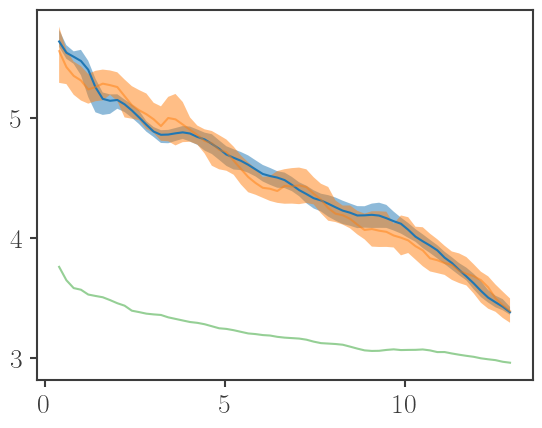

In [17]:
plt.plot(MWRbin_centres/kpc_to_cm, np.log10(MWmedweights[0]/kB_cgs))
plt.fill_between(MWRbin_centres/kpc_to_cm, np.log10(MWq1weights[0]/kB_cgs),
                 y2=np.log10(MWq4weights[0]/kB_cgs), alpha=0.5)
plt.plot(MWRbin_centres/kpc_to_cm, np.log10(MWmedPtots[0]), alpha=0.5)
plt.fill_between(MWRbin_centres/kpc_to_cm, np.log10(MWq1Ptots[0]),
                 y2=np.log10(MWq4Ptots[0]), alpha=0.5)
plt.plot(MWRbin_centres/kpc_to_cm, np.log10(MWmedPths[0]), alpha=0.5)
plt.show()

In [18]:
MWmedSigmag, MWq1Sigmag, MWq4Sigmag = [], [], []
for folder in folders:
    rcs = sorted(glob.glob(os.path.join(
        "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+"/saved-arrays/RomeoQ-data-Sigmag-0.5kpc_*.npy")))
    rcnos = [rc.rsplit('RomeoQ-data-Sigmag-0.5kpc_')[1].rsplit('.npy')[0] for rc in rcs]
    
    Sigmag = np.zeros((MWRbinno, phibinno, len(rcnos)))
    for no, i in zip(rcnos, range(len(rcnos))):
        Sigmag[:,:,i] = np.load(
            "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+
            "/saved-arrays/RomeoQ-data-Sigmag-0.5kpc_"+str(no)+".npy",
            allow_pickle=True
        )
    
    # take median over the time and phi axes simultaneously
    MWmedSigmag.append(np.nanmedian(Sigmag, axis=(1,2)))
    MWq1Sigmag.append(np.nanpercentile(Sigmag, 25, axis=(1,2)))
    MWq4Sigmag.append(np.nanpercentile(Sigmag, 75, axis=(1,2)))

In [19]:
MWmedSigmaH2, MWq1SigmaH2, MWq4SigmaH2 = [], [], []
MWmedSigmaSFRsH2, MWq1SigmaSFRsH2, MWq4SigmaSFRsH2 = [], [], []
for folder in folders:
    rcs = sorted(glob.glob(os.path.join(
        "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+"/saved-arrays/SigmaH2-0.5kpc_*.npy")))
    rcnos = [rc.rsplit('SigmaH2-0.5kpc_')[1].rsplit('.npy')[0] for rc in rcs]
    
    SigmaH2 = np.zeros((MWRbinno, MWphibinno, len(rcnos)))
    SigmaSFRs = np.zeros((MWRbinno, MWphibinno, len(rcnos)))
    for no, i in zip(rcnos, range(len(rcnos))):
        SigmaH2[:,:,i] = np.load(
            "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+
            "/saved-arrays/SigmaH2-0.5kpc_"+str(no)+".npy",
            allow_pickle=True
        )
        SigmaSFRs[:,:,i] = np.load(
            "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+
            "/saved-arrays/SigmaSFR-0.5kpc_"+str(no)+".npy",
            allow_pickle=True
        )/Msol_to_g/1.e6*kpc_to_cm**2 # original in g/cm^2/Myr
    
    # take median over the time and phi axes simultaneously
    SigmaH2[SigmaH2/Msol_to_g*pc_to_cm**2.<=0.] = np.nan
    MWmedSigmaH2.append(np.nanmedian(SigmaH2, axis=(1,2)))
    MWq1SigmaH2.append(np.nanpercentile(SigmaH2, 25, axis=(1,2)))
    MWq4SigmaH2.append(np.nanpercentile(SigmaH2, 75, axis=(1,2)))
    
    meanSigmaSFRs = np.nanmean(SigmaSFRs, axis=1)
    MWmedSigmaSFRsH2.append(np.nanmedian(SigmaSFRs, axis=(1,2)))
    MWq1SigmaSFRsH2.append(np.nanpercentile(meanSigmaSFRs, 25, axis=1))
    MWq4SigmaSFRsH2.append(np.nanpercentile(meanSigmaSFRs, 75, axis=1))

# NGC300

In [20]:
folders = ['NGC300']
NGC300Rmin, NGC300Rmax = 0.3, 6.
NGC300Rbinno = int(np.rint((NGC300Rmax-NGC300Rmin)/(0.2)))
NGC300Rbin_edges =np.linspace(NGC300Rmin, NGC300Rmax, NGC300Rbinno+1) * kpc_to_cm
NGC300Rbin_centres = (NGC300Rbin_edges[1:]+NGC300Rbin_edges[:-1])/2.

NGC300phibinno = 8
NGC300areas = np.zeros((NGC300Rbinno, NGC300phibinno))
for i in range(NGC300phibinno):
    NGC300areas[:,i] = np.pi*(NGC300Rbin_edges[1:]**2-NGC300Rbin_edges[:-1]**2)/NGC300phibinno

zmin, zmax = -1500., 1500.
NGC300zbin_edges = np.linspace(zmin, zmax, zbinno+1) * pc_to_cm # 100-pc slices
NGC300zbin_centres = (NGC300zbin_edges[1:]+NGC300zbin_edges[:-1])/2.
NGC300deltaz = (zmax-zmin)/zbinno*pc_to_cm

NGC300R_grid, NGC300phi_grid, NGC300z_grid = np.meshgrid(NGC300Rbin_centres, phibin_centres, NGC300zbin_centres)

In [21]:
NGC300medSigmaSFRs, NGC300q1SigmaSFRs, NGC300q4SigmaSFRs = [], [], []
NGC300medPturbs, NGC300q1Pturbs, NGC300q4Pturbs = [], [], []
NGC300medPths, NGC300q1Pths, NGC300q4Pths = [], [], []
NGC300medPtots, NGC300q1Ptots, NGC300q4Ptots = [], [], []
NGC300Ptotmeans, NGC300SigmaSFRmeans = [], []
for folder in folders:
    rcs = sorted(glob.glob(os.path.join(
        "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+"/saved-arrays/rotcurve-data-avir-0.5kpc-Pturbs-Tthresh_*.npy")))
    rcnos = [rc.rsplit('rotcurve-data-avir-0.5kpc-Pturbs-Tthresh_')[1].rsplit('.npy')[0] for rc in rcs]
    print(rcnos)
    
    SigmaSFRs = np.zeros((NGC300Rbinno, NGC300phibinno, len(rcnos)))
    Pturbs = np.zeros((NGC300Rbinno, NGC300phibinno, len(rcnos)))
    Pths = np.zeros((NGC300Rbinno, NGC300phibinno, len(rcnos)))
    
    for no, i in zip(rcnos, range(len(rcnos))):
        SigmaSFRs[:,:,i] = np.load(
            "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+
            "/saved-arrays/SigmaSFR-0.5kpc_"+str(no)+".npy",
            allow_pickle=True
        )/Msol_to_g/1.e6*kpc_to_cm**2 # original in g/cm^2/Myr
        Pturbs[:,:,i] = np.load(
            "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+
            "/saved-arrays/rotcurve-data-avir-0.5kpc-Pturbs-Tthresh_"+str(no)+".npy",
            allow_pickle=True
        )
        Pths[:,:,i] = np.load(
            "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+
            "/saved-arrays/rotcurve-data-avir-0.5kpc-Pths-Tthresh_"+str(no)+".npy",
            allow_pickle=True
        )
        NGC300Ptotmeans.append(np.sum((Pturbs[:,:,i]+Pths[:,:,i])*NGC300areas)/np.sum(NGC300areas))
        NGC300SigmaSFRmeans.append(np.sum(SigmaSFRs[:,:,i]*NGC300areas)/np.sum(NGC300areas))
    
    # take median over the time and phi axes simultaneously
    #NGC300medSigmaSFRs.append(np.mean(SigmaSFRs, axis=(1,2)))
    meanSigmaSFRs = np.mean(SigmaSFRs, axis=1)
    NGC300medSigmaSFRs.append(np.nanmedian(meanSigmaSFRs, axis=1))
    #NGC300medSigmaSFRs.append(np.median(SigmaSFRs, axis=(1,2)))
    NGC300q1SigmaSFRs.append(np.percentile(meanSigmaSFRs, 25, axis=1))
    NGC300q4SigmaSFRs.append(np.percentile(meanSigmaSFRs, 75, axis=1))
    
    NGC300medPturbs.append(np.median(Pturbs, axis=(1,2)))
    NGC300q1Pturbs.append(np.percentile(Pturbs, 25, axis=(1,2)))
    NGC300q4Pturbs.append(np.percentile(Pturbs, 75, axis=(1,2)))

    NGC300medPths.append(np.median(Pths, axis=(1,2)))
    NGC300q1Pths.append(np.percentile(Pths, 25, axis=(1,2)))
    NGC300q4Pths.append(np.percentile(Pths, 75, axis=(1,2)))
    
    NGC300medPtots.append(np.median(Pths+Pturbs, axis=(1,2)))
    NGC300q1Ptots.append(np.percentile(Pths+Pturbs, 25, axis=(1,2)))
    NGC300q4Ptots.append(np.percentile(Pths+Pturbs, 75, axis=(1,2)))
NGC300medUpsilons = [1.e5*medPtots_**(-0.235)*10.**4.2 for medPtots_ in NGC300medPtots]
NGC300medUpsilonSigmaSFRs = [medPtots_*kB_cgs/medUpsilons_/Msol_to_g*kpc_to_cm**2*yr_to_s for medPtots_, medUpsilons_ in zip(NGC300medPtots, NGC300medUpsilons)]
NGC300q1UpsilonSigmaSFRs = [q1Ptots_*kB_cgs/medUpsilons_/Msol_to_g*kpc_to_cm**2*yr_to_s for q1Ptots_, medUpsilons_ in zip(NGC300q1Ptots, NGC300medUpsilons)]
NGC300q4UpsilonSigmaSFRs = [q4Ptots_*kB_cgs/medUpsilons_/Msol_to_g*kpc_to_cm**2*yr_to_s for q4Ptots_, medUpsilons_ in zip(NGC300q4Ptots, NGC300medUpsilons)]
NGC300Ptotmeans = np.array(NGC300Ptotmeans)
NGC300SigmaSFRmeans = np.array(NGC300SigmaSFRmeans)

['500', '501', '502', '503', '504', '505', '506', '507', '508', '509', '510', '511', '512', '513', '514', '515', '516', '517', '518', '519', '520', '521', '522', '523', '524', '525', '526', '527', '528', '529', '530', '531', '532', '533', '534', '535', '536', '537', '538', '539', '540', '541', '542', '543', '544', '545', '546', '547', '548', '549', '550', '551', '552', '553', '554', '555', '556', '557', '558', '559', '560', '561', '562', '563', '564', '565', '566', '567', '568', '569', '570', '571', '572', '573', '574', '575', '576', '577', '578', '579', '580', '581', '582', '583', '584', '585', '586', '587', '588', '589', '590', '591', '592', '593', '594', '595', '596', '597', '598', '599', '600', '601', '602', '603', '604', '605', '606', '607', '608', '609', '610', '611', '612', '613', '614', '615', '616', '617', '618', '619', '620', '621', '622', '623', '624', '625', '626', '627', '628', '629', '630', '631', '632', '633', '634', '635', '636', '637', '638', '639', '640', '641', '642'

In [22]:
# NGC300
NGC300medweights, NGC300q1weights, NGC300q4weights = [], [], []
NGC300medweight0s, NGC300q1weight0s, NGC300q4weight0s = [], [], []
NGC300medweight1s, NGC300q1weight1s, NGC300q4weight1s = [], [], []
NGC300medweight2s, NGC300q1weight2s, NGC300q4weight2s = [], [], []
NGC300weightmeans = []
for folder in folders:
    ptls = sorted(glob.glob(os.path.join(
        "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+"/saved-arrays/ptl-MW-NGC300_*.npy")))
    ptlnos = [ptl.rsplit('ptl-MW-NGC300_')[1].rsplit('.npy')[0] for ptl in ptls]
    
    weight = np.zeros((NGC300phibinno, NGC300Rbinno, len(ptlnos)))
    weight0 = np.zeros((NGC300phibinno, NGC300Rbinno, len(ptlnos)))
    weight1 = np.zeros((NGC300phibinno, NGC300Rbinno, len(ptlnos)))
    weight2 = np.zeros((NGC300phibinno, NGC300Rbinno, len(ptlnos)))
    weightmeans_ = []
    print(ptlnos)
    for ptlno, i in zip(ptlnos, range(len(ptlnos))):
        ptl = np.load(
            "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+
            "/saved-arrays/ptl-MW-NGC300_"+str(ptlno)+".npy",
            allow_pickle=True
        )
        ptl1 = np.load(
            "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+
            "/saved-arrays/ptl1-MW-NGC300_"+str(ptlno)+".npy",
            allow_pickle=True
        )
        ptl2 = np.load(
            "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+
            "/saved-arrays/ptl2-MW-NGC300_"+str(ptlno)+".npy",
            allow_pickle=True
        )
        ptl4 = ptl * 0.2
        rho3D = np.load(
            "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+
            "/saved-arrays/rho3Ds-MW-NGC300_"+str(ptlno)+".npy",
            allow_pickle=True
        )
        rho3D = np.swapaxes(rho3D, 0,1)

        # weights
        polyno = 2
        wndwlen = 9

        dz = sg(NGC300z_grid, wndwlen, polyno, deriv=1, axis=2)
        dPhi = sg(ptl, wndwlen, polyno, deriv=1, axis=2)
        dPhidz = 1.5*dPhi/dz
        weight0[:,:,i] = np.sum(np.fabs(rho3D*dPhidz*NGC300deltaz)/2., axis=2)

        dPhi1 = sg(ptl1, wndwlen, polyno, deriv=1, axis=2)
        dPhi1dz = 1.5*dPhi1/dz
        weight1[:,:,i] = np.sum(np.fabs(rho3D*dPhi1dz*NGC300deltaz)/2., axis=2)

        dPhi2 = sg(ptl2, wndwlen, polyno, deriv=1, axis=2)
        dPhi2dz = 1.5*dPhi2/dz
        
        dPhi4 = sg(ptl4, wndwlen, polyno, deriv=1, axis=2)
        dPhi4dz = 1.5*dPhi4/dz
        weight2[:,:,i] = np.sum(np.fabs(rho3D*(dPhi2dz+dPhi4dz)*NGC300deltaz)/2., axis=2)

        dPhitotdz = dPhidz + dPhi1dz + dPhi2dz + dPhi4dz
        weight[:,:,i] = np.sum(np.fabs(rho3D*dPhitotdz*NGC300deltaz)/2., axis=2)
        
        weightmeans_.append(np.average(weight[:,:,i]))#, weights=NGC300R_grid[:,:,0]))
        
    print(np.shape(weight[:,:,i]))
        
    NGC300medweights.append(np.median(weight, axis=(0,2)))
    NGC300q1weights.append(np.percentile(weight, 25, axis=(0,2)))
    NGC300q4weights.append(np.percentile(weight, 75, axis=(0,2)))
    
    NGC300medweight0s.append(np.median(weight0, axis=(0,2)))
    NGC300q1weight0s.append(np.percentile(weight0, 25, axis=(0,2)))
    NGC300q4weight0s.append(np.percentile(weight0, 75, axis=(0,2)))
    
    NGC300medweight1s.append(np.median(weight1, axis=(0,2)))
    NGC300q1weight1s.append(np.percentile(weight1, 25, axis=(0,2)))
    NGC300q4weight1s.append(np.percentile(weight1, 75, axis=(0,2)))
    
    NGC300medweight2s.append(np.median(weight2, axis=(0,2)))
    NGC300q1weight2s.append(np.percentile(weight2, 25, axis=(0,2)))
    NGC300q4weight2s.append(np.percentile(weight2, 75, axis=(0,2)))
    
    NGC300weightmeans.append(weightmeans_)

['500', '501', '505', '506', '510', '511', '515', '516', '520', '521', '525', '526', '530', '531', '535', '536', '540', '541', '545', '546', '550', '551', '555', '556', '560', '561', '565', '566', '570', '571', '575', '576', '580', '581', '585', '586', '590', '591', '595', '596', '600', '601', '605', '606', '610', '611', '615', '616', '620', '621', '625', '626', '630', '631', '635', '636', '640', '641', '645', '646', '650', '651', '655', '656', '660', '661', '665', '666', '670', '671', '675', '676', '680', '681', '685', '686', '690', '691', '695', '696', '700', '701', '705', '706', '710', '711', '715', '716', '720', '721', '725', '726', '730', '731', '735', '736', '740', '741', '745', '746', '750', '751', '755', '756', '760', '761', '765', '766', '770', '771', '775', '776', '780', '781', '785', '786', '790', '791', '795', '796', '800']
(8, 28)


28 28


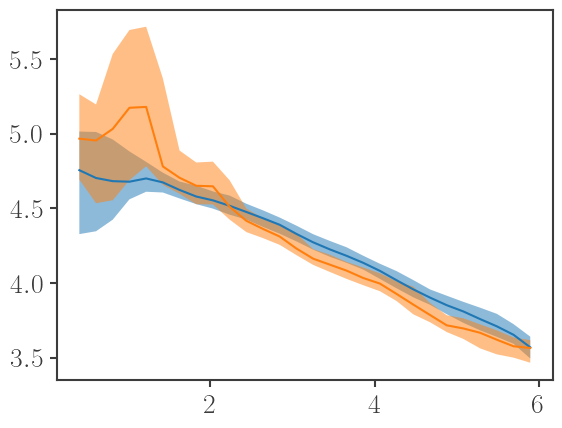

In [23]:
print(len(NGC300q1weights[0]), len(NGC300Rbin_centres))
plt.plot(NGC300Rbin_centres/kpc_to_cm, np.log10(NGC300medweights[0]/kB_cgs))
plt.fill_between(NGC300Rbin_centres/kpc_to_cm, np.log10(NGC300q1weights[0]/kB_cgs), y2=np.log10(NGC300q4weights[0]/kB_cgs), alpha=0.5)
plt.plot(NGC300Rbin_centres/kpc_to_cm, np.log10(NGC300medPtots[0]))
plt.fill_between(NGC300Rbin_centres/kpc_to_cm, np.log10(NGC300q1Ptots[0]), y2=np.log10(NGC300q4Ptots[0]), alpha=0.5)

In [24]:
NGC300medSigmag, NGC300q1Sigmag, NGC300q4Sigmag = [], [], []
for folder in folders:
    rcs = sorted(glob.glob(os.path.join(
        "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+"/saved-arrays/RomeoQ-data-Sigmag-0.5kpc_*.npy")))
    rcnos = [rc.rsplit('RomeoQ-data-Sigmag-0.5kpc_')[1].rsplit('.npy')[0] for rc in rcs]
    
    Sigmag = np.zeros((NGC300Rbinno, phibinno, len(rcnos)))
    for no, i in zip(rcnos, range(len(rcnos))):
        Sigmag[:,:,i] = np.load(
            "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+
            "/saved-arrays/RomeoQ-data-Sigmag-0.5kpc_"+str(no)+".npy",
            allow_pickle=True
        )
    
    # take median over the time and phi axes simultaneously
    NGC300medSigmag.append(np.nanmedian(Sigmag, axis=(1,2)))
    NGC300q1Sigmag.append(np.nanpercentile(Sigmag, 25, axis=(1,2)))
    NGC300q4Sigmag.append(np.nanpercentile(Sigmag, 75, axis=(1,2)))

In [25]:
NGC300medSigmaH2, NGC300q1SigmaH2, NGC300q4SigmaH2 = [], [], []
NGC300medSigmaSFRsH2, NGC300q1SigmaSFRsH2, NGC300q4SigmaSFRsH2 = [], [], []
for folder in folders:
    rcs = sorted(glob.glob(os.path.join(
        "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+"/saved-arrays/SigmaH2-0.5kpc_*.npy")))
    rcnos = [rc.rsplit('SigmaH2-0.5kpc_')[1].rsplit('.npy')[0] for rc in rcs]
    
    SigmaH2 = np.zeros((NGC300Rbinno, NGC300phibinno, len(rcnos)))
    SigmaSFRs = np.zeros((NGC300Rbinno, NGC300phibinno, len(rcnos)))
    for no, i in zip(rcnos, range(len(rcnos))):
        SigmaH2[:,:,i] = np.load(
            "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+
            "/saved-arrays/SigmaH2-0.5kpc_"+str(no)+".npy",
            allow_pickle=True
        )
        SigmaSFRs[:,:,i] = np.load(
            "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+
            "/saved-arrays/SigmaSFR-0.5kpc_"+str(no)+".npy",
            allow_pickle=True
        )/Msol_to_g/1.e6*kpc_to_cm**2 # original in g/cm^2/Myr
    
    # take median over the time and phi axes simultaneously
    SigmaH2[SigmaH2/Msol_to_g*pc_to_cm**2.<=0.] = np.nan
    NGC300medSigmaH2.append(np.nanmedian(SigmaH2, axis=(1,2)))
    NGC300q1SigmaH2.append(np.nanpercentile(SigmaH2, 25, axis=(1,2)))
    NGC300q4SigmaH2.append(np.nanpercentile(SigmaH2, 75, axis=(1,2)))
    
    meanSigmaSFRs = np.mean(SigmaSFRs, axis=1)
    NGC300medSigmaSFRsH2.append(np.nanmedian(SigmaSFRs, axis=(1,2)))
    NGC300q1SigmaSFRsH2.append(np.nanpercentile(meanSigmaSFRs, 25, axis=1))
    NGC300q4SigmaSFRsH2.append(np.nanpercentile(meanSigmaSFRs, 75, axis=1))

# figure

In [26]:
labels = [r"$\mathbf{M_*=10^{10}{\rm M}_\odot}$",
          r"$\mathbf{M_*=10^{10.5}{\rm M}_\odot}$",
          r"$\mathbf{M_*=10^{11}{\rm M}_\odot}$",
          r"$\mathbf{M_*=10^{11.5}{\rm M}_\odot}$",
          r"Milky Way-like",
          r"NGC~300-like"]

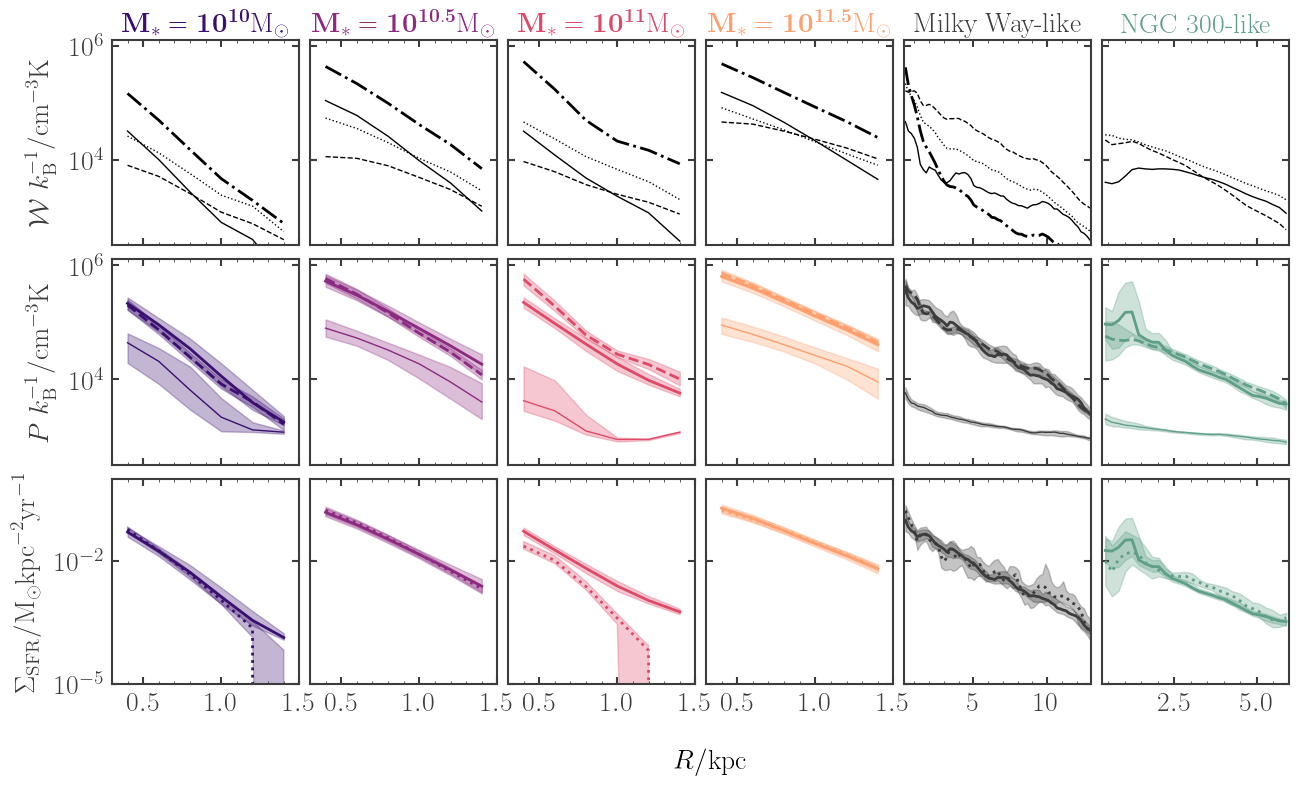

In [27]:
figW = 15
figH = 7
fig = plt.figure(figsize=(figW, figH))

botMarg = 0.1
wBetMarg = 0.007
topMarg = 0.02
leftMarg = 0.1
hBetMarg = 0.02

crightMarg = 0.105
cW = 0.015
cBet = 0.002
rightMarg = 0.03 + crightMarg + cW

h = (1.0-topMarg-botMarg)/3
w = (1.0-leftMarg-rightMarg)/6

### axes ###
# veldisps
ax0 = fig.add_axes([leftMarg, botMarg+(h+hBetMarg), w, h], ylim=[10.**2.5, 10.**6.1], xlim=[0.3, 1.5],
                 xlabel='', xticklabels='', ylabel=r'$P~k_{\rm B}^{-1}/{\rm cm}^{-3} {\rm K}$')
ax1 = fig.add_axes([leftMarg+w+wBetMarg, botMarg+(h+hBetMarg), w, h], ylim=[10.**2.5, 10.**6.1], xlim=[0.3, 1.5],
                 xlabel='', ylabel='', xticklabels='', yticklabels='')
ax2 = fig.add_axes([leftMarg+2*(w+wBetMarg), botMarg+(h+hBetMarg), w, h], ylim=[10.**2.5, 10.**6.1], xlim=[0.3, 1.5],
                 xlabel='', ylabel='', xticklabels='', yticklabels='')
ax3 = fig.add_axes([leftMarg+3*(w+wBetMarg), botMarg+(h+hBetMarg), w, h], ylim=[10.**2.5, 10.**6.1], xlim=[0.3, 1.5],
                 xlabel='', ylabel='', xticklabels='', yticklabels='')
ax4 = fig.add_axes([leftMarg+4*(w+wBetMarg), botMarg+(h+hBetMarg), w, h], ylim=[10.**2.5, 10.**6.1], xlim=[0.3, 13.],
                 xlabel='', ylabel='', xticklabels='', yticklabels='')
ax5 = fig.add_axes([leftMarg+5*(w+wBetMarg), botMarg+(h+hBetMarg), w, h], ylim=[10.**2.5, 10.**6.1], xlim=[0.3, 6.],
                 xlabel='', ylabel='', xticklabels='', yticklabels='')
axs = [ax0, ax1, ax2, ax3, ax4, ax5]

ax10 = fig.add_axes([leftMarg, botMarg, w, h], xlim=[0.3, 1.5], ylim=[10.**(-5.), 1.], 
                 xlabel='', ylabel=r'$\Sigma_{\rm SFR}/{\rm M}_\odot {\rm kpc}^{-2} {\rm yr}^{-1}$')
ax11 = fig.add_axes([leftMarg+w+wBetMarg, botMarg, w, h], xlim=[0.3, 1.5], ylim=[10.**(-5.), 1.], 
                 xlabel='', ylabel='', yticklabels='')
ax12 = fig.add_axes([leftMarg+2*(w+wBetMarg), botMarg, w, h], xlim=[0.3, 1.5], ylim=[10.**(-5.), 1.], 
                 xlabel=r'', ylabel='', yticklabels='')
ax13 = fig.add_axes([leftMarg+3*(w+wBetMarg), botMarg, w, h], xlim=[0.3, 1.5], ylim=[10.**(-5.), 1.], 
                 xlabel='', ylabel='', yticklabels='')
ax14 = fig.add_axes([leftMarg+4*(w+wBetMarg), botMarg, w, h], xlim=[0.3, 13.], ylim=[10.**(-5.), 1.], 
                 xlabel='', ylabel='', yticklabels='')
ax15 = fig.add_axes([leftMarg+5*(w+wBetMarg), botMarg, w, h], xlim=[0.3, 6.], ylim=[10.**(-5.), 1.], 
                 xlabel='', ylabel='', yticklabels='')
axs1 = [ax10, ax11, ax12, ax13, ax14, ax15]
    
ax20 = fig.add_axes([leftMarg, botMarg+2*(h+hBetMarg), w, h], ylim=[10.**2.5, 10.**6.1], xlim=[0.3, 1.5],
                 xlabel='', xticklabels='',
                    ylabel=r'$\mathcal{W}~k_{\rm B}^{-1}/{\rm cm}^{-3} {\rm K}$')
ax21 = fig.add_axes([leftMarg+w+wBetMarg, botMarg+2*(h+hBetMarg), w, h], ylim=[10.**2.5, 10.**6.1], xlim=[0.3, 1.5],
                 xlabel='', ylabel='', yticklabels='', xticklabels='')
ax22 = fig.add_axes([leftMarg+2*(w+wBetMarg), botMarg+2*(h+hBetMarg), w, h], ylim=[10.**2.5, 10.**6.1], xlim=[0.3, 1.5],
                 xlabel='', ylabel='', yticklabels='', xticklabels='')
ax23 = fig.add_axes([leftMarg+3*(w+wBetMarg), botMarg+2*(h+hBetMarg), w, h], ylim=[10.**2.5, 10.**6.1], xlim=[0.3, 1.5],
                 xlabel='', ylabel='', yticklabels='', xticklabels='')
ax24 = fig.add_axes([leftMarg+4*(w+wBetMarg), botMarg+2*(h+hBetMarg), w, h], ylim=[10.**2.5, 10.**6.1], xlim=[0.3, 13.],
                 xlabel='', ylabel='', yticklabels='', xticklabels='')
ax25 = fig.add_axes([leftMarg+5*(w+wBetMarg), botMarg+2*(h+hBetMarg), w, h], ylim=[10.**2.5, 10.**6.1], xlim=[0.3, 6.],
                 xlabel='', ylabel='', yticklabels='', xticklabels='')
axs2 = [ax20, ax21, ax22, ax23, ax24, ax25]
for ax, label, i in zip(axs2, labels, range(len(axs))):
    ax.set_title(label, color=plt.cm.magma(float(i+1)/5.), fontsize=20)
    if(i==4):
        ax.set_title(label, color='#3C3C3C', fontsize=20)
    if(i==5):
        ax.set_title(label, color='#5E9F87', fontsize=20)
    
fig.text(0.475, -0.02, r'$R/{\rm kpc}$')

### plot stuff
# weight vs. pressure
for i, ax, medweights_, q1weights_, q4weights_, medPtots_, q1Ptots_, q4Ptots_, medPths_, q1Pths_, q4Pths_ in zip(
    range(len(axs)), axs, medweights, q1weights, q4weights, medPtots, q1Ptots, q4Ptots, medPths, q1Pths, q4Pths):
    c=plt.cm.magma((i+1)/5)
    ax.plot(Rbin_centres/kpc_to_cm, medweights_/kB_cgs, color=c, lw=2, ls='dashed', label='total')
    ax.fill_between(Rbin_centres/kpc_to_cm, q1weights_/kB_cgs,
                    y2=q4weights_/kB_cgs, alpha=0.3, color=c)
    
    ax.plot(Rbin_centres/kpc_to_cm, medPtots_, color=c, lw=2, label='total')
    ax.fill_between(Rbin_centres/kpc_to_cm, q1Ptots_,
                    y2=q4Ptots_, alpha=0.3, color=c)

    ax.plot(Rbin_centres/kpc_to_cm, medPths_, color=c, lw=1, label='total')
    ax.fill_between(Rbin_centres/kpc_to_cm, q1Pths_,
                    y2=q4Pths_, alpha=0.3, color=c)
    
# MW
ax4.plot(MWRbin_centres/kpc_to_cm, MWmedweights[0]/kB_cgs,
         color='#3C3C3C', lw=2, ls='dashed', label=r'')
ax4.fill_between(MWRbin_centres/kpc_to_cm, MWq1weights[0]/kB_cgs,
                y2=MWq4weights[0]/kB_cgs, alpha=0.3, color='#3C3C3C')

ax4.plot(MWRbin_centres/kpc_to_cm, MWmedPtots[0],
         color='#3C3C3C', lw=2, label='')
ax4.fill_between(MWRbin_centres/kpc_to_cm, MWq1Ptots[0],
                y2=MWq4Ptots[0], alpha=0.3, color='#3C3C3C')

ax4.plot(MWRbin_centres/kpc_to_cm, MWmedPths[0],
         color='#3C3C3C', lw=1, label='')
ax4.fill_between(MWRbin_centres/kpc_to_cm, MWq1Pths[0],
                y2=MWq4Pths[0], alpha=0.3, color='#3C3C3C')
    
# NGC300
ax5.plot(NGC300Rbin_centres/kpc_to_cm, NGC300medweights[0]/kB_cgs,
         color='#5E9F87', lw=2, ls='dashed')
ax5.fill_between(NGC300Rbin_centres/kpc_to_cm, NGC300q1weights[0]/kB_cgs,
                y2=NGC300q4weights[0]/kB_cgs, alpha=0.3, color='#5E9F87')

ax5.plot(NGC300Rbin_centres/kpc_to_cm, NGC300medPtots[0],
         color='#5E9F87', lw=2)
ax5.fill_between(NGC300Rbin_centres/kpc_to_cm, NGC300q1Ptots[0],
                y2=NGC300q4Ptots[0], alpha=0.3, color='#5E9F87')

ax5.plot(NGC300Rbin_centres/kpc_to_cm, NGC300medPths[0],
         color='#5E9F87', lw=1)
ax5.fill_between(NGC300Rbin_centres/kpc_to_cm, NGC300q1Pths[0],
                y2=NGC300q4Pths[0], alpha=0.3, color='#5E9F87')
    
# pressure vs. SFR
for i, ax, medSigmaSFRs_, q1SigmaSFRs_, q4SigmaSFRs_ in zip(
    range(len(axs1)), axs1, medSigmaSFRs, q1SigmaSFRs, q4SigmaSFRs):
    c=plt.cm.magma((i+1)/5)
    
    q1SigmaSFRs_plt = q1SigmaSFRs_.copy()
    q1SigmaSFRs_plt[q1SigmaSFRs_plt==0.] = 1.e-30
    ax.plot(Rbin_centres/kpc_to_cm, medSigmaSFRs_,
            color=c, lw=2, ls='dotted', label='total')
    ax.fill_between(Rbin_centres/kpc_to_cm, q1SigmaSFRs_plt,
                    y2=q4SigmaSFRs_, alpha=0.3, color=c)
    ax.plot(Rbin_centres/kpc_to_cm, medUpsilonSigmaSFRs[i],
            color=c, lw=2, label='total')
    ax.fill_between(Rbin_centres/kpc_to_cm, q1UpsilonSigmaSFRs[i],
                    y2=q4UpsilonSigmaSFRs[i], alpha=0.3, color=c)
    
MWq1SigmaSFRs_plt = MWq1SigmaSFRs[0].copy()
MWq1SigmaSFRs_plt[MWq1SigmaSFRs_plt==0.] = 1.e-30
ax14.plot(MWRbin_centres/kpc_to_cm, MWmedSigmaSFRs[0],
         color='#3C3C3C', lw=2, ls='dotted')
ax14.fill_between(MWRbin_centres/kpc_to_cm, MWq1SigmaSFRs_plt,
                y2=MWq4SigmaSFRs[0], alpha=0.3, color='#3C3C3C')
ax14.plot(MWRbin_centres/kpc_to_cm, MWmedUpsilonSigmaSFRs[0],
         color='#3C3C3C', lw=2)
ax14.fill_between(MWRbin_centres/kpc_to_cm, MWq1UpsilonSigmaSFRs[0],
                y2=MWq4UpsilonSigmaSFRs[0], alpha=0.3, color='#3C3C3C')

NGC300q1SigmaSFRs_plt = NGC300q1SigmaSFRs[0].copy()
NGC300q1SigmaSFRs_plt[NGC300q1SigmaSFRs_plt==0.] = 1.e-30
ax15.plot(NGC300Rbin_centres/kpc_to_cm, NGC300medSigmaSFRs[0],
         color='#5E9F87', lw=2, ls='dotted')
ax15.fill_between(NGC300Rbin_centres/kpc_to_cm, NGC300q1SigmaSFRs_plt,
                y2=NGC300q4SigmaSFRs[0], alpha=0.3, color='#5E9F87')
ax15.plot(NGC300Rbin_centres/kpc_to_cm, NGC300medUpsilonSigmaSFRs[0],
         color='#5E9F87', lw=2)
ax15.fill_between(NGC300Rbin_centres/kpc_to_cm, NGC300q1UpsilonSigmaSFRs[0],
                y2=NGC300q4UpsilonSigmaSFRs[0], alpha=0.3, color='#5E9F87')

# weight contributions
for i, ax in zip(range(4), axs2):
    ax.plot(Rbin_centres/kpc_to_cm, medweight0s[i]/kB_cgs, lw=1, color='k')
    ax.plot(Rbin_centres/kpc_to_cm, medweight1s[i]/kB_cgs, lw=1, color='k', ls='dotted')
    ax.plot(Rbin_centres/kpc_to_cm, medweight2s[i]/kB_cgs, lw=1, color='k', ls='dashed')
    ax.plot(Rbin_centres/kpc_to_cm, medweight3s[i]/kB_cgs, lw=2, color='k', ls='-.')

ax24.plot(MWRbin_centres/kpc_to_cm, MWmedweight0s[0]/kB_cgs, lw=1, color='k',
          label='gas')
ax24.plot(MWRbin_centres/kpc_to_cm, MWmedweight1s[0]/kB_cgs, lw=1, color='k', ls='dotted',
          label='dark matter')
ax24.plot(MWRbin_centres/kpc_to_cm, MWmedweight2s[0]/kB_cgs, lw=1, color='k', ls='dashed',
          label='disk')
ax24.plot(MWRbin_centres/kpc_to_cm, MWmedweight3s[0]/kB_cgs, lw=2, color='k', ls='-.',
          label='bulge')
    
ax25.plot(NGC300Rbin_centres/kpc_to_cm, NGC300medweight0s[0]/kB_cgs, lw=1, color='k')
ax25.plot(NGC300Rbin_centres/kpc_to_cm, NGC300medweight1s[0]/kB_cgs, lw=1, color='k', ls='dotted')
ax25.plot(NGC300Rbin_centres/kpc_to_cm, NGC300medweight2s[0]/kB_cgs, lw=1, color='k', ls='dashed')

for ax in axs+axs1+axs2:
    ax.set_yscale('log')
    
for ax in axs[1:]+axs1[1:]+axs2[1:]:
    ax.set_yticklabels('')
    
for ax in axs+axs1+axs2:
    ax.tick_params(axis = 'both', bottom = True, top = True, left = True, right = True,
                   which = 'both', direction='in')
    ax.minorticks_on()

# legend, data
legend1 = ax24.legend(
    loc='lower center', bbox_to_anchor=(-1.15, 1.4), ncol=4, frameon=False, handlelength=1.25, columnspacing=0.75
)

custom_lines = [Line2D([0], [0], color='k', ls='dashed', lw=2),
                Line2D([0], [0], color='k', lw=2),
                Line2D([0], [0], color='k', lw=1),
                Line2D([0], [0], color='k', ls='dotted', lw=2)]
legend2 = ax24.legend(
    custom_lines, [r'ISM weight ($\mathcal{W}$)',
                   r'total pressure ($P_{\rm tot}$)',
                   r'thermal pressure ($P_{\rm th}$)',
                   r'SFR surface density ($\Sigma_{\rm SFR}$)'
                  ],
    loc='lower center', bbox_to_anchor=(-1.15, 1.15), ncol=4, frameon=False, handlelength=1, columnspacing=0.75
)
ax24.add_artist(legend1)
ax24.add_artist(legend2)

plt.savefig(
    '/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/figs/rotcurves.pdf',
    bbox_inches='tight',
    format='pdf'
)

plt.show()

# overall plot of SFR against pressure, compared to observations from PHANGS and ATLAS-3D

In [28]:
# get the expected weights for the ETGs in the ATLAS-3D/MASSIVE samples
# (and compare to their stellar surface densities)
from astropy.table import Table

#return the angular size of a length at a given distance
def calc_ang_size(extent, distance, unit): #make sure that your distances are both in the same unit! 
    size = extent/distance
    
    if "rad" in unit:
        return size
    elif "deg" in unit:
        return size*(180/np.pi)
    elif "arcsec" in unit:
        return size*(180/np.pi)*3600

def calc_physical_size(angular_size, distance, unit): #will return result in the same unit as distance
    physical_size = angular_size*distance
    
    if "rad" in unit:
        return physical_size
    elif "deg" in unit:
        return physical_size*(np.pi/180.)
    elif "arc" in unit:
        return physical_size*(np.pi/180.)/3600.
    
### set up various calculation functions ###

def calc_c(mhalo_msun, h):
    return 10**(0.905-0.101*np.log10(mhalo_msun/(1e12*(1/h))))

def multf(conc):
    num = np.sqrt(2*(np.log(1+conc)-(conc/(1+conc))))
    fac = num/conc
    pf = 1+ fac
    return pf*pf

def m200(mhalo, conc):
    return mhalo/multf(conc)

def fc(c):
    return c * (0.5 - 0.5 / pow(1 + c, 2) - np.log(1 + c) / (1 + c)) / pow(np.log(1 + c) - c / (1 + c), 2)

def r200(vc,h):
    return vc/(10*h)

def scale_length(c, LAMBDA, vc, h):
    return sqrt(2.0) / 2.0 * LAMBDA / fc(c) * r200(vc, h)

def vc(mhalo, c, h):
    m2 = m200(mhalo, c)
    return pow(10*m2*4300*h, 1./3.)

def calc_M200(v200, G, h):
    return 1e9 * pow(v200, 3) / (G * h)

def calc_logMstar(MKS):
    return 10.58 - 0.44 * (MKS+23)

In [29]:
A3Dt1 = Table.read("/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/data/Atlas3D_galproperties_table1.txt",
                   format="ascii", names=["Galaxy", "RA", "DEC", "SBF", "NED-D","Virgo", "VHel", "D", "M_K", "A_B", "T-type", "log(Re)"])
A3Dt2 = Table.read("/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/data/A3Dsfrt2.txt", format="ascii")#, 
                   #names=["Galaxy", "Area","pm","Area Error", "Source", "log ΣHI+H2" , "pm","log ΣHI+H2 Error", "τdyn","τff","F22 μm", "F22 μm, corr", "pm", "F22 μm, corr Error", 
                   #       "FFUV", "pm", "FFUV Error" , "ΣSFR, 22 μm", "pm", "ΣSFR, 22 μm Error", "ΣSFR, FUV + 22 μm", "pm", "ΣSFR, FUV + 22 μm Error"])
A3Dt3 = Table.read("/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/data/Atlas3D_galproperties_table3.txt",
                   format="ascii", 
                   names=["Galaxy", "logSig_e", "R(sig)/Re", "logSig_kpc", "inc", "logML_JAM", "logVc^max", "quality", 
                          "logRe^maj", "logRe", "logR_1/2", "logR_g", "conc", "eps_e", "logLum"])
A3Dt4 = Table.read("/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/data/Atlas3D_gasext.txt",
                   format="ascii")
print(A3Dt4.keys())
#RCO is in kpc already
A3Dt5 = Table.read("/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/data/Atlas3D_galproperties_table4.txt",
                   format="ascii") 
Mt1 = Table.read("/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/data/MASSIVE_table_2.txt", format="ascii")
Msizes = Table.read("/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/data/MASSIVE_sizes.txt", format="ascii")
WISDOM_distances = {"NGC0383": 66.6, "NGC0708": 58.3, "NGC7052":51.6, "NGC3862": 92.5, "NGC5208":97.15, "IC0310":58.60, "NGC0467":73.40, "NGC0665":71.20, "NGC0997":92.9, "NGC1684":61.5, "NGC7550": 65.7}#, "NGC7750":}
Mt2 = Table.read("/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/data/MASSIVE_table_3.txt", format="ascii")

['Galaxy', 'R25', 'DCO', 'θGPA', 'RCO', 'RCORe', 'RCOR25', 'log(RCOLKs)', 'Reference']


In [30]:
# Atlas 3D
A3Dt1["log(Re)kpc"] = np.log10(pow(10, A3Dt1["log(Re)"])*((np.pi/180.)/3600.)*1e3*A3Dt1["D"])
RCOs_dict = {}
for i in range(len(A3Dt4['RCORe'])):
    RCOs_dict[A3Dt4['Galaxy'][i]] = A3Dt4['RCORe'][i]
print(RCOs_dict)

SFR_22mm = []
SFR_22mmErr = []
SFR_comb = []
SFR_combErr = []
Mgas = []
MgasE = []
for i, SFRSD22t in enumerate(A3Dt2["ΣSFR, 22μm"][:]):
    a = float(A3Dt2["Area"][i][:5])
    aErr = float(A3Dt2["Area"][i][-5:])
    try:
        SFRSD22 = float(SFRSD22t[:5])        
    except ValueError:
        try:
            SFRSD22 = -float(SFRSD22t[1:5])
        except ValueError:
            SFRSD22 = np.NaN
            
    try:
        SFRSD22E = float(SFRSD22t[-5:])
    except ValueError:
        SFRSD22E = np.NaN

    try:
        SFRSDc = float(A3Dt2["ΣSFR, FUV + 22μm"][i][:5])
    except ValueError:
        try:
            SFRSDc = -float(A3Dt2["ΣSFR, FUV + 22μm"][i][1:5])
        except ValueError:
            SFRSDc = np.NaN
            
    try:
        SFRSDcE = float(A3Dt2["ΣSFR, FUV + 22μm"][i][-5:]) 
    except ValueError:
        SFRSDcE = np.NaN
        
    gasSD = float(A3Dt2["log ΣHI+H2"][i][:5])
    gasSDE = float(A3Dt2["log ΣHI+H2"][i][-5:])
    
    logA = np.log10(a)
    logAE = aErr/a/np.log(10)
    
    SFR_22mm.append(logA+SFRSD22)
    SFR_22mmErr.append(np.sqrt(pow(logAE,2)+pow(SFRSD22E,2)))
    SFR_comb.append(logA+SFRSDc)
    SFR_combErr.append(np.sqrt(pow(logAE,2)+pow(SFRSDcE, 2)))
    Mgas.append(logA+6+gasSD) #need to account for the conversion of kpc2 to pc2 for gasSD
    MgasE.append(np.sqrt(pow(logAE,2)+pow(gasSDE,2)))
    
A3Dt2["logSFR22µm"] = SFR_22mm
A3Dt2["logSFR22µmerr"] = SFR_22mmErr
A3Dt2["logSFR22µmFUV"] = SFR_comb
A3Dt2["logSFR22µmFUVerr"] = SFR_combErr
A3Dt2["logMgas"] = Mgas
A3Dt2["logMgasErr"] = MgasE

logMstar = [] 
for i, logLum in enumerate(A3Dt3["logLum"]):
    try:
        logMstar.append(float(A3Dt3["logML_JAM"][i])+float(logLum))
    except ValueError:
        logMstar.append(np.NaN)
        
A3Dt3["logMstar"] = logMstar
A3Dt2["logMgasMstarrat"] = [A3Dt2["logMgas"][i]-A3Dt3["logMstar"][np.where(name[:-1]==A3Dt3["Galaxy"])] for i, name in enumerate(A3Dt2["Galaxy"])]
A3Dt2["fgas"] = [pow(10,A3Dt2["logMgas"][i])/(pow(10, A3Dt2["logMgas"][i])+pow(10,A3Dt3["logMstar"][np.where(name[:-1]==A3Dt3["Galaxy"])]))
                 for i, name in enumerate(A3Dt2["Galaxy"])] # need the extra :-1 in name, because it's str length 10 in tab2, but length 9 in tab3
estimated_M200 = []
for i, logVcirc in enumerate(A3Dt3["logVc^max"]):
    try:
        estimated_M200.append(calc_M200(pow(10, float(logVcirc)), 4300, 0.72))
    except ValueError:
        estimated_M200.append(np.NaN)
A3Dt3["logM200"] = np.log10(estimated_M200)

{'IC0676': 0.46, 'IC0719': 0.48, 'IC1024': 1.08, 'NGC0524': 0.21, 'NGC1222': 1.0, 'NGC1266': 0.22, 'NGC2697': 0.64, 'NGC2764': 1.45, 'NGC2768': 0.1, 'NGC2824': 1.03, 'NGC3032': 0.54, 'NGC3182': 0.34, 'NGC3489': 0.43, 'NGC3607': 0.36, 'NGC3619': 0.13, 'NGC3626': 0.5, 'NGC3665': 0.32, 'NGC4119': 0.2, 'NGC4150': 0.78, 'NGC4292': 0.15, 'NGC4324': 1.19, 'NGC4429': 0.14, 'NGC4435': 0.11, 'NGC4459': 0.19, 'NGC4476': 0.6, 'NGC4477': 0.07, 'NGC4526': 0.13, 'NGC4550': 0.26, 'NGC4694': 0.43, 'NGC4710': 0.96, 'NGC4753': 0.29, 'NGC5379': 0.97, 'NGC5866': 0.86, 'NGC6014': 0.12, 'NGC7465': 1.75, 'PGC029321': 0.55, 'PGC058114': 0.72, 'UGC05408': 0.43, 'UGC06176': 0.16, 'UGC09519': 0.77}


In [31]:
# Plummer bulge, Omega = sqrt(G*M)/(R^2+a^2)^(3/4)
Hg = 25.*pc_to_cm
xid = 1./3.

# NFW DM halo, Rs = 1/C sqrt(3*V200^2/4/pi/G * 1/200/rhocrit)
C = 10.
H = 2.2E-18 # hubble constant, cgs
rhocrit = 3.*H**2 / 8. / np.pi / G_cgs

SFRsds_ATLAS3D_RCO, SFRsds_ATLAS3D_noRCO = [], []
weights_ATLAS3D_RCO, weights_ATLAS3D_noRCO = [], []
weights_g_ATLAS3D_RCO, weights_g_ATLAS3D_noRCO = [], []
weights_sdm_ATLAS3D_RCO, weights_sdm_ATLAS3D_noRCO = [], []
fgas_ATLAS3D_RCO, fgas_ATLAS3D_noRCO = [], []
Omega2s_ATLAS3D_RCO, Omega2s_ATLAS3D_noRCO = [], []
taudeps_ATLAS3D_RCO, taudeps_ATLAS3D_noRCO = [], []
for i, lname in enumerate(A3Dt2["Galaxy"]):
    name = lname[:-1]
    fgas = pow(10, A3Dt2["logMgasMstarrat"][i])
    Mstar = pow(10, A3Dt3["logMstar"][i]) * Msol_to_g
    Re = pow(10, A3Dt1["log(Re)kpc"][i]) * kpc_to_cm
    M200 = pow(10, A3Dt3["logM200"][i]) * Msol_to_g
    
    if name in A3Dt4["Galaxy"]:
        try:
            RCO = RCOs_dict[name]
            Rvals = np.linspace(0.001*kpc_to_cm, RCO * kpc_to_cm, 30)
            HIH2sd = float(A3Dt2["log ΣHI+H2"][i][:5])
            SFRsd = float(A3Dt2["ΣSFR, FUV + 22μm"][i][:5])
        except ValueError:
            try:
                RCO = RCOs_dict[name]
                Rvals = np.linspace(0.001*kpc_to_cm, RCO * kpc_to_cm, 30)
                HIH2sd = float(A3Dt2["log ΣHI+H2"][i][:5])
                SFRsd = -float(A3Dt2["ΣSFR, FUV + 22μm"][i][1:5])
            except ValueError:
                pass
        SFRsds_ATLAS3D_RCO.append(SFRsd)
        HIH2sd = 10.**HIH2sd * Msol_to_g / pc_to_cm**2
        R200 = (M200/200./rhocrit / 4./np.pi * 3.)**(1./3.)
        V200 = np.sqrt(G_cgs * M200 / R200)
        
        dPhibdR = Rvals * G_cgs * Mstar / (Rvals**2 + (1.3*Re)**2)**1.5
        Omegab2 = np.median(dPhibdR / Rvals)
        rhoRs3 = M200/4./np.pi / (np.log(C+1.) + 1./(C+1.)-1.)
        Rs = 1./C * np.sqrt(3.*V200**2/4./np.pi/G_cgs * 1./200./rhocrit)
        dPhiddR = 4.*np.pi*G_cgs * rhoRs3 * (-1./Rvals/(Rvals+Rs) + 1./Rvals/Rvals * np.log(Rvals/Rs + 1.))
        Omegad2 = np.median(dPhiddR / Rvals)
        Omega2 = np.median((dPhibdR + dPhiddR) / Rvals)
        
        weight_g = np.pi*G_cgs * HIH2sd**2/2.
        weight_s = xid*HIH2sd*Omegab2*Hg
        weight_dm = xid*HIH2sd*Omegad2*Hg
        weights_ATLAS3D_RCO.append(weight_g+weight_s+weight_dm)
        weights_g_ATLAS3D_RCO.append(weight_g)
        weights_sdm_ATLAS3D_RCO.append(weight_s+weight_dm)
        fgas_ATLAS3D_RCO.append(fgas)
        Omega2s_ATLAS3D_RCO.append(Omega2)
        taudeps_ATLAS3D_RCO.append(HIH2sd/(10.**SFRsd * Msol_to_g / pc_to_cm**2))
        
    else:
        Rvals = np.linspace(0.001*kpc_to_cm, 1.5 * kpc_to_cm, 30)
        try:
            HIH2sd = float(A3Dt2["log ΣHI+H2"][i][:5])
            SFRsd = float(A3Dt2["ΣSFR, FUV + 22μm"][i][:5])
        except ValueError:
            try:
                HIH2sd = float(A3Dt2["log ΣHI+H2"][i][:5])
                SFRsd = -float(A3Dt2["ΣSFR, FUV + 22μm"][i][1:5])
            except ValueError:
                pass
        SFRsds_ATLAS3D_noRCO.append(SFRsd)
        HIH2sd = 10.**HIH2sd * Msol_to_g / pc_to_cm**2
        R200 = (M200/200./rhocrit / 4./np.pi * 3.)**(1./3.)
        V200 = np.sqrt(G_cgs * M200 / R200)
        
        dPhibdR = Rvals * G_cgs * Mstar / (Rvals**2 + (1.3*Re)**2)**1.5
        Omegab2 = np.median(dPhibdR / Rvals)
        rhoRs3 = M200/4./np.pi / (np.log(C+1.) + 1./(C+1.)-1.)
        Rs = 1./C * np.sqrt(3.*V200**2/4./np.pi/G_cgs * 1./200./rhocrit)
        dPhiddR = 4.*np.pi*G_cgs * rhoRs3 * (-1./Rvals/(Rvals+Rs) + 1./Rvals/Rvals * np.log(Rvals/Rs + 1.))
        Omegad2 = np.median(dPhiddR / Rvals)
        Omega2 = np.median((dPhibdR + dPhiddR) / Rvals)
      
        weight_g = np.pi*G_cgs * HIH2sd**2/2.
        weight_s = xid*HIH2sd*Omegab2*Hg
        weight_dm = xid*HIH2sd*Omegad2*Hg
        weights_ATLAS3D_noRCO.append(weight_g+weight_s+weight_dm)
        weights_g_ATLAS3D_noRCO.append(weight_g)
        weights_sdm_ATLAS3D_noRCO.append(weight_s+weight_dm)
        fgas_ATLAS3D_noRCO.append(fgas)
        Omega2s_ATLAS3D_noRCO.append(Omega2)
        taudeps_ATLAS3D_noRCO.append(HIH2sd/(10.**SFRsd * Msol_to_g / pc_to_cm**2))
SFRsds_ATLAS3D_RCO = np.array(SFRsds_ATLAS3D_RCO)
SFRsds_ATLAS3D_noRCO = np.array(SFRsds_ATLAS3D_noRCO)
weights_g_ATLAS3D_RCO = np.array(weights_g_ATLAS3D_RCO)
weights_g_ATLAS3D_noRCO = np.array(weights_g_ATLAS3D_noRCO)
weights_sdm_ATLAS3D_RCO = np.array(weights_sdm_ATLAS3D_RCO)
weights_sdm_ATLAS3D_noRCO = np.array(weights_sdm_ATLAS3D_noRCO)
weights_ATLAS3D_RCO = np.array(weights_ATLAS3D_RCO)
weights_ATLAS3D_noRCO = np.array(weights_ATLAS3D_noRCO)
fgas_ATLAS3D_RCO = np.array(fgas_ATLAS3D_RCO)
fgas_ATLAS3D_noRCO = np.array(fgas_ATLAS3D_noRCO)
Omega2s_ATLAS3D_RCO = np.array(Omega2s_ATLAS3D_RCO)
Omega2s_ATLAS3D_noRCO = np.array(Omega2s_ATLAS3D_noRCO)
taudeps_ATLAS3D_RCO = np.array(taudeps_ATLAS3D_RCO)
taudeps_ATLAS3D_noRCO = np.array(taudeps_ATLAS3D_noRCO)

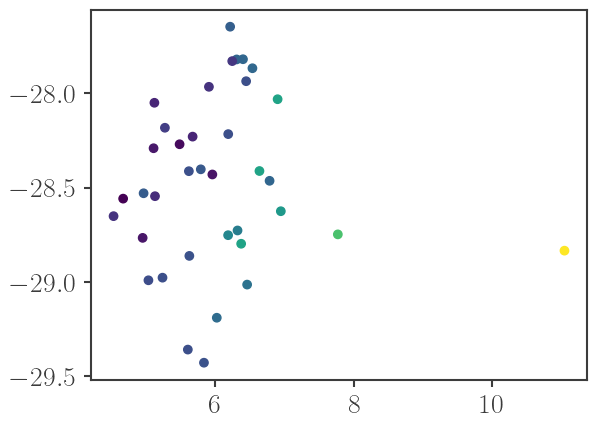

In [32]:
plt.scatter(np.log10(weights_ATLAS3D_RCO/kB_cgs), np.log10(Omega2s_ATLAS3D_RCO),
            c=SFRsds_ATLAS3D_RCO)
#plt.scatter(np.log10(weights_ATLAS3D_noRCO/kB_cgs), SFRsds_ATLAS3D_noRCO, c=np.log10(Omega2s_ATLAS3D_noRCO))
plt.show()

In [33]:
# PHANGS data
J23 = Table.read("/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/data/Sun+23.txt",
                   format="ascii")#, names=["Galaxy", "RA", "DEC", "SBF", "NED-D","Virgo", "VHel", "D", "M_K", "A_B", "T-type", "log(Re)"])
print(J23.keys())
PDE_J23 = J23['P-DE-S20']
ePDE_J23 = J23['e_P-DE-S20']
Sigmamol_J23 = J23['Sigma-mol-S20']
Sigmamol_J23 = J23['e_Sigma-mol-S20']
SFR_J23 = J23['Sigma-SFR-HaW4recal']
eSFR_J23 = J23['e_Sigma-SFR-HaW4recal']

['Name', 'RAdeg', 'DEdeg', 'Sigma-SFR-HaW4recal', 'e_Sigma-SFR-HaW4recal', 'Sigma-SFR-FUVW4recal', 'e_Sigma-SFR-FUVW4recal', 'Sigma-SFR-Hacorr', 'e_Sigma-SFR-Hacorr', 'Sigma-mol-S20', 'e_Sigma-mol-S20', 'Sigma-mol-MW', 'e_Sigma-mol-MW', 'Sigma-mol-B13', 'e_Sigma-mol-B13', 'Sigma-mol-G20', 'e_Sigma-mol-G20', 'Sigma-mol-per-t-orb-S20', 'e_Sigma-mol-per-t-orb-S20', 'Sigma-mol-per-t-orb-MW', 'e_Sigma-mol-per-t-orb-MW', 'Sigma-mol-per-t-orb-B13', 'e_Sigma-mol-per-t-orb-B13', 'Sigma-mol-per-t-orb-G20', 'e_Sigma-mol-per-t-orb-G20', 'Sigma-mol-per-t-ff-S20', 'e_Sigma-mol-per-t-ff-S20', 'Sigma-mol-per-t-ff-MW', 'e_Sigma-mol-per-t-ff-MW', 'Sigma-mol-per-t-ff-B13', 'e_Sigma-mol-per-t-ff-B13', 'Sigma-mol-per-t-ff-G20', 'e_Sigma-mol-per-t-ff-G20', 'P-DE-S20', 'e_P-DE-S20', 'P-DE-MW', 'e_P-DE-MW', 'P-DE-B13', 'e_P-DE-B13', 'P-DE-G20', 'e_P-DE-G20']


In [34]:
# Sigma SFRs from KS relation figure
folders = ['ETGs/vlM-output', 'ETGs/lowM-output', 'ETGs/medM-output', 'ETGs/hiM-output']
medSigmaSFRsKS, q1SigmaSFRsKS, q4SigmaSFRsKS = [], [], []
for folder in folders:
    data = np.genfromtxt(
        "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+"/saved-arrays/KS-relation-data.txt"
    )
    medSigmaSFRsKS.append(np.median(data.T[3])/Msol_to_g*pc_to_cm**2)
    q1SigmaSFRsKS.append(np.percentile(data.T[3], 25)/Msol_to_g*pc_to_cm**2)
    q4SigmaSFRsKS.append(np.percentile(data.T[3], 75)/Msol_to_g*pc_to_cm**2)
medSigmaSFRsKS = np.array(medSigmaSFRsKS)
q1SigmaSFRsKS = np.array(q1SigmaSFRsKS)
q4SigmaSFRsKS = np.array(q4SigmaSFRsKS)

In [35]:
from astropy.io import ascii as asciitable

In [36]:
# bigiel data
xlim = [-1., 3.5]
ylim = [-4.3, -0.5]

# plot specs
n = 1000
nbin = 30
xgrd = np.linspace(xlim[0], xlim[1], nbin)
ygrd = np.linspace(ylim[0], ylim[1], nbin)
xx, yy = np.meshgrid(xgrd, ygrd)

# obs data
data_bigiel = asciitable.read('/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/data/bigiel.txt', Reader=asciitable.Cds)
Sigma_S1_Bigiel = np.array(data_bigiel["logSFR"])
Sigma_S2_Bigiel = np.array(data_bigiel["logSFR"])
Sigma_S3_Bigiel = np.array(data_bigiel["logSFR"])
Sigma_H2_Bigiel = np.array(data_bigiel["logH2"])
Sigma_HI_Bigiel = np.array(data_bigiel["logHI"])
Sigma_HIH2_Bigiel = np.log10(10**Sigma_H2_Bigiel + 10**Sigma_HI_Bigiel)
cnd = ((Sigma_HIH2_Bigiel != 0.0) & (np.array(data_bigiel["logSFR"]) != 0.0))
Sigma_S2_Bigiel = Sigma_S2_Bigiel[cnd]
Sigma_HIH2_Bigiel = Sigma_HIH2_Bigiel[cnd]

xHIH2 = Sigma_HIH2_Bigiel[(Sigma_HIH2_Bigiel > xlim[0]) & (Sigma_S2_Bigiel > ylim[0])]
yHIH2 = Sigma_S2_Bigiel[(Sigma_HIH2_Bigiel > xlim[0]) & (Sigma_S2_Bigiel > ylim[0])]
xyHIH2 = np.array([xHIH2, yHIH2])
kdeHIH2 = gaussian_kde(xyHIH2)
denHIH2 = kdeHIH2(np.array([xx.ravel(), yy.ravel()])).reshape(xx.shape)
denHIH2_normalized = denHIH2 / denHIH2.sum()
tHIH2 = np.linspace(0, denHIH2_normalized.max(), n)
integralHIH2 = ((denHIH2_normalized >= tHIH2[:, None, None]) * denHIH2_normalized).sum(axis=(1,2))

fHIH2 = interpolate.interp1d(integralHIH2, tHIH2)

In [37]:
# galaxy-averaged values
folder = 'MW-tracers'
nos = np.linspace(300, 600, 301, dtype=int)

# need to compile all the files
# R SigmaH2HI SigmaH2 SigmaSFR SFR Mstar Sigmastar
sdSFRs_MW = []
for no in nos:
    # unit mistake in ETGs_KS-relations-MW-MW.py, multiplied by Myr_to_s erroneously, needed to /5 instead
    sdSFR_MW = np.load("/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+"/saved-arrays/KS-relation-data_sdSFR"+str(no)+".npy",
            allow_pickle=True) / Myr_to_s / 5. * 3.154/3.08
    sdSFRs_MW.append(list(np.ravel(sdSFR_MW)))
sdSFRs_MW = np.array(flatten_list(sdSFRs_MW))

cnd = (sdSFRs_MW>0)
medsdSFRs_MW = np.median(sdSFRs_MW[cnd])
q1sdSFRs_MW = np.percentile(sdSFRs_MW[cnd], 25)
q4sdSFRs_MW = np.percentile(sdSFRs_MW[cnd], 75)

In [38]:
folder = 'NGC300'
nos = np.linspace(500, 800, 301, dtype=int)

# need to compile all the files
# R SigmaH2HI SigmaH2 SigmaSFR SFR Mstar Sigmastar
sdSFRs_NGC300 = []
for no in nos:
    # unit mistake in ETGs_KS-relations-MW-MW.py, multiplied by Myr_to_s erroneously, needed to /5 instead
    sdSFR_NGC300 = np.load("/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+"/saved-arrays/KS-relation-data_sdSFR"+str(no)+".npy",
            allow_pickle=True) / Myr_to_s / 5. * 3.154/3.08
    sdSFRs_NGC300.append(list(np.ravel(sdSFR_NGC300)))
sdSFRs_NGC300 = np.array(flatten_list(sdSFRs_NGC300))

cnd = (sdSFRs_NGC300>0)
medsdSFRs_NGC300 = np.median(sdSFRs_NGC300[cnd])
q1sdSFRs_NGC300 = np.percentile(sdSFRs_NGC300[cnd], 25)
q4sdSFRs_NGC300 = np.percentile(sdSFRs_NGC300[cnd], 75)

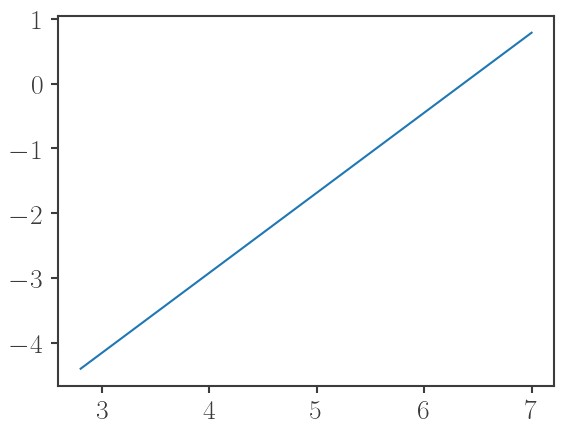

In [39]:
xU = 10.**np.linspace(2.8, 7., 30)
xU_cgs = xU*kB_cgs
yU_cgs = xU_cgs/(100.*1.e5)
yU_100 = yU_cgs/Msol_to_g*kpc_to_cm**2*yr_to_s
yU_cgs = xU_cgs/(1000.*1.e5)
yU_1000 = yU_cgs/Msol_to_g*kpc_to_cm**2*yr_to_s
yU_cgs = xU_cgs/(10000.*1.e5)
yU_10000 = yU_cgs/Msol_to_g*kpc_to_cm**2*yr_to_s

UpsilonUT_cgs = 1.e5*(xU_cgs/kB_cgs)**(-0.235)*10.**4.2
yUT = 10.**(1.235*np.log10(xU_cgs/kB_cgs)-7.86)
#yUT_cgs = xU_cgs/UpsilonUT_cgs
#yUT = yUT_cgs/Msol_to_g*kpc_to_cm**2*yr_to_s

plt.plot(np.log10(xU), np.log10(yUT))
plt.show()

/tmp/ipykernel_2532441/81120973.py:32: RuntimeWarning: divide by zero encountered in log10
  density_contours.density_contour(np.log10(J23['P-DE-S20']), np.log10(J23['Sigma-SFR-HaW4recal']),
/n/home03/sjeffreson/notebooks/density_contours.py:273: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  contourfunc(
/tmp/ipykernel_2532441/81120973.py:93: RuntimeWarning: divide by zero encountered in log10
  ax0.scatter(np.log10(medPtots[i]), np.log10(medSigmaSFRs[i]), s=50, color=plt.cm.magma(float(i+1)/5.), zorder=3)
/tmp/ipykernel_2532441/81120973.py:94: RuntimeWarning: divide by zero encountered in log10
  ax0.scatter(np.log10(medPtots[i]), np.log10(medSigmaSFRs[i]), s=100, color='white', zorder=2)
/tmp/ipykernel_2532441/81120973.py:181: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(medweights[i]/kB_cgs), np.log10(medSigmaSFRs[i]), s=50, color=plt.cm.magma(float(i+1)/5.), zorder=3)
/tmp/ipykernel_2532441/81120973.py:182: RuntimeWarning: d

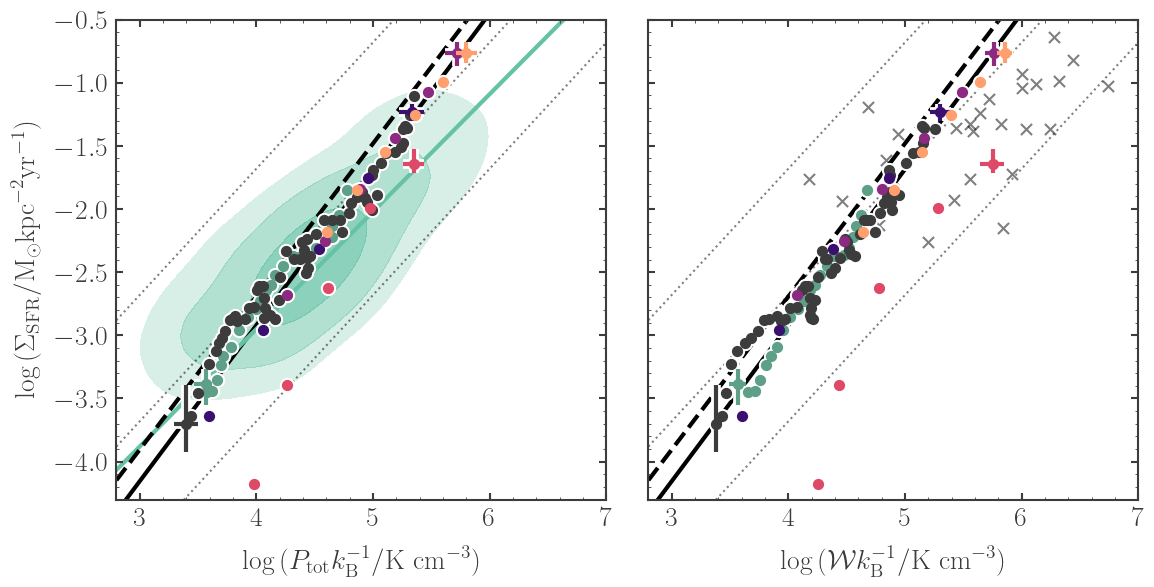

In [40]:
figW = 14
figH = 6
fig = plt.figure(figsize=(figW, figH))

topMarg = 0.1
leftMarg = 0.15
botMarg = 0.1
rightMarg = 0.15

wBetMarg = 0.03
hBetMarg = 0.01

crightMarg = 0.105
cW = 0.04
cBet = 0.02

h = (1.0-topMarg-botMarg)
w = (1.0-leftMarg-rightMarg)/2

### axes ###
ax0 = fig.add_axes([leftMarg, botMarg, w, h], xlim=[2.8, 7.], ylim=[-4.3, -0.5],
                  xlabel=r'$\log{(P_{\rm tot} k_{\rm B}^{-1}/{\rm K~cm}^{-3})}$',
                  ylabel=r'$\log{(\Sigma_{\rm SFR}/{\rm M}_\odot {\rm kpc}^{-2}{\rm yr}^{-1})}$')
ax1 = fig.add_axes([leftMarg+w+wBetMarg, botMarg, w, h], xlim=[2.8, 7.], ylim=[-4.3, -0.5],
                  xlabel=r'$\log{(\mathcal{W} k_{\rm B}^{-1}/{\rm K~cm}^{-3})}$',
                  ylabel=r'', yticklabels='') 
axs = [ax0, ax1]

# plot stuff
# obs data
# PHANGS
density_contours.density_contour(np.log10(J23['P-DE-S20']), np.log10(J23['Sigma-SFR-HaW4recal']),
                                 xscale='linear', yscale='linear', ax=ax0,  color=plt.cm.Set2(0),
                                 edgecolor='None',
                                 levels=(0.4, 0.8, 0.95), xlim=[2.8, 7.], ylim=[-4.3, -0.5])
# density_contours.density_contour(np.log10(np.array(weights_g_ATLAS3D_RCO/kB_cgs)),
#                                  SFRsds_ATLAS3D_RCO, color=plt.cm.Set2(1),
#                                  edgecolor='None',
#                                  xscale='linear', yscale='linear', ax=ax1,
#                                  levels=(0.4, 0.8, 0.95), xlim=[2.8, 7.], ylim=[-4.3, -0.5])

ax1.scatter(np.log10(np.array(weights_g_ATLAS3D_RCO/kB_cgs)),
                                 SFRsds_ATLAS3D_RCO, color='k', marker='x', alpha=0.5, s=64)
ax1.set_yticklabels('')
for ax in axs:
    ax.tick_params(axis = 'both', bottom = True, top = True, left = True, right = True,
                   which = 'both', direction='in')
    ax.minorticks_on()

# ETGs
viridis_r_tiny = mpl.cm.ScalarMappable(norm=LogNorm(vmin=5e-4, vmax=5e-2), cmap=plt.get_cmap("viridis"))
viridis_r_tiny._A = []

# sim data
# NGC300
ax0.scatter(np.log10(NGC300medPtots[0][5:]), np.log10(NGC300medSigmaSFRs[0][5:]), s=50, color='#5E9F87', zorder=3)
ax0.scatter(np.log10(NGC300medPtots[0][5:]), np.log10(NGC300medSigmaSFRs[0][5:]), s=100, color='white', zorder=2)

# one error bar
ax0.vlines(np.log10(NGC300medPtots[0][-1]), np.log10(NGC300q1SigmaSFRs[0][-1]),
           ymax=np.log10(NGC300q4SigmaSFRs[0][-1]),
           lw=3, color='#5E9F87', zorder=3)
ax0.vlines(np.log10(NGC300medPtots[0][-1]), np.log10(NGC300q1SigmaSFRs[0][-1]),
           ymax=np.log10(NGC300q4SigmaSFRs[0][-1]),
           lw=7, color='white', zorder=2)
ax0.hlines(np.log10(NGC300medSigmaSFRs[0][-1]), np.log10(NGC300q1Ptots[0][-1]),
           xmax=np.log10(NGC300q4Ptots[0][-1]),
           lw=3, color='#5E9F87', zorder=3)
ax0.hlines(np.log10(NGC300medSigmaSFRs[0][-1]), np.log10(NGC300q1Ptots[0][-1]),
           xmax=np.log10(NGC300q4Ptots[0][-1]),
           lw=7, color='white', zorder=2)

# MW
ax0.scatter(np.log10(MWmedPtots[0][2:]), np.log10(MWmedSigmaSFRs[0][2:]), s=50, color='#3C3C3C', zorder=3)
ax0.scatter(np.log10(MWmedPtots[0][2:]), np.log10(MWmedSigmaSFRs[0][2:]), s=100, color='white', zorder=2)

# one error bar
ax0.vlines(np.log10(MWmedPtots[0][-1]), np.log10(MWq1SigmaSFRs[0][-1]),
           ymax=np.log10(MWq4SigmaSFRs[0][-1]),
           lw=3, color='#3C3C3C', zorder=3)
ax0.vlines(np.log10(MWmedPtots[0][-1]), np.log10(MWq1SigmaSFRs[0][-1]),
           ymax=np.log10(MWq4SigmaSFRs[0][-1]),
           lw=7, color='white', zorder=2)
ax0.hlines(np.log10(MWmedSigmaSFRs[0][-1]), np.log10(MWq1Ptots[0][-1]),
           xmax=np.log10(MWq4Ptots[0][-1]),
           lw=3, color='#3C3C3C', zorder=3)
ax0.hlines(np.log10(MWmedSigmaSFRs[0][-1]), np.log10(MWq1Ptots[0][-1]),
           xmax=np.log10(MWq4Ptots[0][-1]),
           lw=7, color='white', zorder=2)

# ETGs
for i in range(4):
    ax0.scatter(np.log10(medPtots[i]), np.log10(medSigmaSFRs[i]), s=50, color=plt.cm.magma(float(i+1)/5.), zorder=3)
    ax0.scatter(np.log10(medPtots[i]), np.log10(medSigmaSFRs[i]), s=100, color='white', zorder=2)

    # one error bar
    ax0.vlines(np.log10(medPtots[i][0]), np.log10(q1SigmaSFRs[i][0]),
               ymax=np.log10(q4SigmaSFRs[i][0]),
               lw=3, color=plt.cm.magma(float(i+1)/5.), zorder=3)
    ax0.vlines(np.log10(medPtots[i][0]), np.log10(q1SigmaSFRs[i][0]),
               ymax=np.log10(q4SigmaSFRs[i][0]),
               lw=7, color='white', zorder=2)
    ax0.hlines(np.log10(medSigmaSFRs[i][0]), np.log10(q1Ptots[i][0]),
               xmax=np.log10(q4Ptots[i][0]),
               lw=3, color=plt.cm.magma(float(i+1)/5.), zorder=3)
    ax0.hlines(np.log10(medSigmaSFRs[i][0]), np.log10(q1Ptots[i][0]),
               xmax=np.log10(q4Ptots[i][0]),
               lw=7, color='white', zorder=2)
    
# lines of constant Upsilon
xU = 10.**np.linspace(2.8, 7., 30)
xU_cgs = xU*kB_cgs
yU_cgs = xU_cgs/(100.*1.e5)
yU_100 = yU_cgs/Msol_to_g*kpc_to_cm**2*yr_to_s
yU_cgs = xU_cgs/(1000.*1.e5)
yU_1000 = yU_cgs/Msol_to_g*kpc_to_cm**2*yr_to_s
yU_cgs = xU_cgs/(10000.*1.e5)
yU_10000 = yU_cgs/Msol_to_g*kpc_to_cm**2*yr_to_s

UpsilonUT_cgs = 1.e5*(xU_cgs/kB_cgs)**(-0.235)*10.**4.2
yUT = 10.**(1.235*np.log10(xU_cgs/kB_cgs)-7.86)
#yUT_cgs = xU_cgs/UpsilonUT_cgs
#yUT = yUT_cgs/Msol_to_g*kpc_to_cm**2*yr_to_s

# Sun et al. 2023 best fit, fiducial
alpha, beta = -2.95, 0.93
yUS23 = 10.**alpha * (xU_cgs/1.e4/kB_cgs)**beta

# TIGRESS, Equation 25c of Ostriker & Kim 2022
UpsilonUTi_cgs = 10.**5 * 10.**(-0.212 * np.log10(xU_cgs/kB_cgs) + 3.86)
yUTi_cgs = xU_cgs/UpsilonUTi_cgs
yUTi = yUTi_cgs/Msol_to_g*kpc_to_cm**2*yr_to_s

ax0.plot(np.log10(xU), np.log10(yU_100), color='k', ls='dotted', zorder=1, alpha=0.5)
ax0.plot(np.log10(xU), np.log10(yU_1000), color='k', ls='dotted', zorder=1, alpha=0.5)
ax0.plot(np.log10(xU), np.log10(yU_10000), color='k', ls='dotted', zorder=1, alpha=0.5)
ax0.plot(np.log10(xU), np.log10(yUT), color='k', lw=3, zorder=1)
ax0.plot(np.log10(xU), np.log10(yUS23), color=plt.cm.Set2(0), lw=3, zorder=1)
ax0.plot(np.log10(xU), np.log10(yUTi), color='k', lw=3, zorder=1, ls='dashed')

# against weights
# sim data
# NGC300
ax1.scatter(np.log10(NGC300medweights[0][5:]/kB_cgs), np.log10(NGC300medSigmaSFRs[0][5:]), s=50, color='#5E9F87', zorder=3)
ax1.scatter(np.log10(NGC300medweights[0][5:]/kB_cgs), np.log10(NGC300medSigmaSFRs[0][5:]), s=100, color='white', zorder=2)

# one error bar
ax1.vlines(np.log10(NGC300medweights[0][-1]/kB_cgs), np.log10(NGC300q1SigmaSFRs[0][-1]),
           ymax=np.log10(NGC300q4SigmaSFRs[0][-1]),
           lw=3, color='#5E9F87', zorder=3)
ax1.vlines(np.log10(NGC300medweights[0][-1]/kB_cgs), np.log10(NGC300q1SigmaSFRs[0][-1]),
           ymax=np.log10(NGC300q4SigmaSFRs[0][-1]),
           lw=7, color='white', zorder=2)
ax1.hlines(np.log10(NGC300medSigmaSFRs[0][-1]), np.log10(NGC300q1weights[0][-1]/kB_cgs),
           xmax=np.log10(NGC300q4weights[0][-1]/kB_cgs),
           lw=3, color='#5E9F87', zorder=3)
ax1.hlines(np.log10(NGC300medSigmaSFRs[0][-1]), np.log10(NGC300q1weights[0][-1]/kB_cgs),
           xmax=np.log10(NGC300q4weights[0][-1]/kB_cgs),
           lw=7, color='white', zorder=2)

# MW
ax1.scatter(np.log10(MWmedweights[0][5:]/kB_cgs), np.log10(MWmedSigmaSFRs[0][5:]), s=50, color='#3C3C3C', zorder=3)
ax1.scatter(np.log10(MWmedweights[0][5:]/kB_cgs), np.log10(MWmedSigmaSFRs[0][5:]), s=100, color='white', zorder=2)

# one error bar
ax1.vlines(np.log10(MWmedweights[0][-1]/kB_cgs), np.log10(MWq1SigmaSFRs[0][-1]),
           ymax=np.log10(MWq4SigmaSFRs[0][-1]),
           lw=3, color='#3C3C3C', zorder=3)
ax1.vlines(np.log10(MWmedweights[0][-1]/kB_cgs), np.log10(MWq1SigmaSFRs[0][-1]),
           ymax=np.log10(MWq4SigmaSFRs[0][-1]),
           lw=7, color='white', zorder=2)
ax1.hlines(np.log10(MWmedSigmaSFRs[0][-1]), np.log10(MWq1weights[0][-1]/kB_cgs),
           xmax=np.log10(MWq4weights[0][-1]/kB_cgs),
           lw=3, color='#3C3C3C', zorder=3)
ax1.hlines(np.log10(MWmedSigmaSFRs[0][-1]), np.log10(MWq1weights[0][-1]/kB_cgs),
           xmax=np.log10(MWq4weights[0][-1]/kB_cgs),
           lw=7, color='white', zorder=2)

# ETGs
for i in range(4):
    ax1.scatter(np.log10(medweights[i]/kB_cgs), np.log10(medSigmaSFRs[i]), s=50, color=plt.cm.magma(float(i+1)/5.), zorder=3)
    ax1.scatter(np.log10(medweights[i]/kB_cgs), np.log10(medSigmaSFRs[i]), s=100, color='white', zorder=2)

    # one error bar
    ax1.vlines(np.log10(medweights[i][0]/kB_cgs), np.log10(q1SigmaSFRs[i][0]),
               ymax=np.log10(q4SigmaSFRs[i][0]),
               lw=3, color=plt.cm.magma(float(i+1)/5.), zorder=3)
    ax1.vlines(np.log10(medweights[i][0]/kB_cgs), np.log10(q1SigmaSFRs[i][0]),
               ymax=np.log10(q4SigmaSFRs[i][0]),
               lw=7, color='white', zorder=2)
    ax1.hlines(np.log10(medSigmaSFRs[i][0]), np.log10(q1weights[i][0]/kB_cgs),
               xmax=np.log10(q4weights[i][0]/kB_cgs),
               lw=3, color=plt.cm.magma(float(i+1)/5.), zorder=3)
    ax1.hlines(np.log10(medSigmaSFRs[i][0]), np.log10(q1weights[i][0]/kB_cgs),
               xmax=np.log10(q4weights[i][0]/kB_cgs),
               lw=7, color='white', zorder=2)

# NGC300
medP = np.median(NGC300weightmeans[0])/kB_cgs
q1P = np.percentile(NGC300weightmeans[0], 25)/kB_cgs
q4P = np.percentile(NGC300weightmeans[0], 75)/kB_cgs
medSS = medsdSFRs_NGC300
q1SS = q1sdSFRs_NGC300
q4SS = q4sdSFRs_NGC300

# MW
medP = np.median(MWweightmeans[0])/kB_cgs
q1P = np.percentile(MWweightmeans[0], 25)/kB_cgs
q4P = np.percentile(MWweightmeans[0], 75)/kB_cgs
medSS = medsdSFRs_MW
q1SS = q1sdSFRs_MW
q4SS = q4sdSFRs_MW

# ETGs
# for i in range(4):
#     medP = np.median(weightmeans[i])/kB_cgs
#     medSS = medSigmaSFRsKS[i]
#     q1P = np.percentile(weightmeans[i], 25)/kB_cgs
#     q4P = np.percentile(weightmeans[i], 75)/kB_cgs
#     q1SS = q1SigmaSFRsKS[i]
#     q4SS = q4SigmaSFRsKS[i]
    
#     ax1.scatter(np.log10(medP), np.log10(medSS), s=200, marker='o', color='white', zorder=3)
#     ax1.scatter(np.log10(medP), np.log10(medSS), s=64, marker='x', lw=3, color=plt.cm.magma(float(i+1)/5.), zorder=4)

# lines of constant Upsilon
ax1.plot(np.log10(xU), np.log10(yU_100), color='k', ls='dotted', zorder=1, alpha=0.5)
ax1.plot(np.log10(xU), np.log10(yU_1000), color='k', ls='dotted', zorder=1, alpha=0.5)
ax1.plot(np.log10(xU), np.log10(yU_10000), color='k', ls='dotted', zorder=1, alpha=0.5)
ax1.plot(np.log10(xU), np.log10(yUT), color='k', lw=3, zorder=1)
ax1.plot(np.log10(xU), np.log10(yUTi), color='k', lw=3, zorder=1, ls='dashed')

# legend, data
custom_lines = [Line2D([0], [0], marker='s', markeredgecolor='None', markerfacecolor=plt.cm.Set2(0),
                       markersize=15, lw=0),
                Line2D([0], [0], marker='x', markeredgecolor='k',
                       markersize=12, alpha=0.5, lw=0),
                Line2D([0], [0], color='k', ls='dashed', lw=3)]
legend1 = ax1.legend(
    custom_lines, ['PHANGS, Sun et al. 2023', 'ATLAS-3D, Davis et al. 2013', 'TIGRESS, Ostriker \& Kim 2022'],
    loc='lower center', bbox_to_anchor=(-0.1, 1.01), ncol=3, frameon=False, handlelength=1, columnspacing=0.75
)

# legend, sims
custom_lines = [Line2D([0], [0], marker='o', markerfacecolor=plt.cm.magma(1./5.),
                       markeredgecolor='white', markersize=12.5, lw=0),
                Line2D([0], [0], marker='o', markerfacecolor=plt.cm.magma(2./5.),
                       markeredgecolor='white', markersize=12.5, lw=0),
                Line2D([0], [0], marker='o', markerfacecolor=plt.cm.magma(3./5.),
                       markeredgecolor='white', markersize=12.5, lw=0),
                Line2D([0], [0], marker='o', markerfacecolor=plt.cm.magma(4./5.),
                       markeredgecolor='white', markersize=12.5, lw=0),
                Line2D([0], [0], marker='o', markerfacecolor='#3C3C3C',
                       markeredgecolor='white', markersize=12.5, lw=0),
                Line2D([0], [0], marker='o', markerfacecolor='#5E9F87', markeredgewidth=2,
                       markeredgecolor='white', markersize=12.5, lw=3)]
legend2 = ax1.legend(
    custom_lines, [r'', r'', r'', r'ETG simulations', r'Milky Way-like', r'NGC~300-like'],
    loc='lower center', bbox_to_anchor=(-0.1, 1.1), ncol=6, frameon=False, handlelength=0.2, columnspacing=0.75
)
ax1.add_artist(legend1)
ax1.add_artist(legend2)

plt.savefig(
    '/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/figs/obs-comparison-pressures.pdf',
    bbox_inches='tight',
    format='pdf'
)

plt.show()

In [42]:
# version with prediction from SH03
logsurfdenses_SH03_bincentres = np.load(
    "/n/holystore01/LABS/itc_lab/Users/sjeffreson/LtU-arrays/logsurfdenses_SH03_bincentres.npy")
med_logSigmaSFR_SH03 = np.load("/n/holystore01/LABS/itc_lab/Users/sjeffreson/LtU-arrays/med_logSigmaSFR_SH03.npy")
q1_logSigmaSFR_SH03 = np.load("/n/holystore01/LABS/itc_lab/Users/sjeffreson/LtU-arrays/q1_logSigmaSFR_SH03.npy")
q4_logSigmaSFR_SH03 = np.load("/n/holystore01/LABS/itc_lab/Users/sjeffreson/LtU-arrays/q4_logSigmaSFR_SH03.npy")

/tmp/ipykernel_3565724/4221005591.py:31: UserWarning: linewidths is ignored by contourf
  ax0.contourf(denHIH2_normalized, [fHIH2(0.95), 1], linewidths=2., colors=[plt.cm.Set2(2)], linestyles='dotted',
/tmp/ipykernel_3565724/4221005591.py:33: UserWarning: linewidths is ignored by contourf
  ax0.contourf(denHIH2_normalized, [fHIH2(0.8), 1], linewidths=2., colors=[plt.cm.Set2(2)], linestyles='dashed',
/tmp/ipykernel_3565724/4221005591.py:35: UserWarning: linewidths is ignored by contourf
  ax0.contourf(denHIH2_normalized, [fHIH2(0.4), 1], linewidths=2., colors=[plt.cm.Set2(2)], linestyles='solid',
/tmp/ipykernel_3565724/4221005591.py:104: RuntimeWarning: divide by zero encountered in log10
  ax0.scatter(np.log10(medSigmag[i]/Msol_to_g*pc_to_cm**2), np.log10(medSigmaSFRs[i]),
/tmp/ipykernel_3565724/4221005591.py:106: RuntimeWarning: divide by zero encountered in log10
  ax0.scatter(np.log10(medSigmag[i]/Msol_to_g*pc_to_cm**2), np.log10(medSigmaSFRs[i]),
/tmp/ipykernel_3565724/4221005591.p

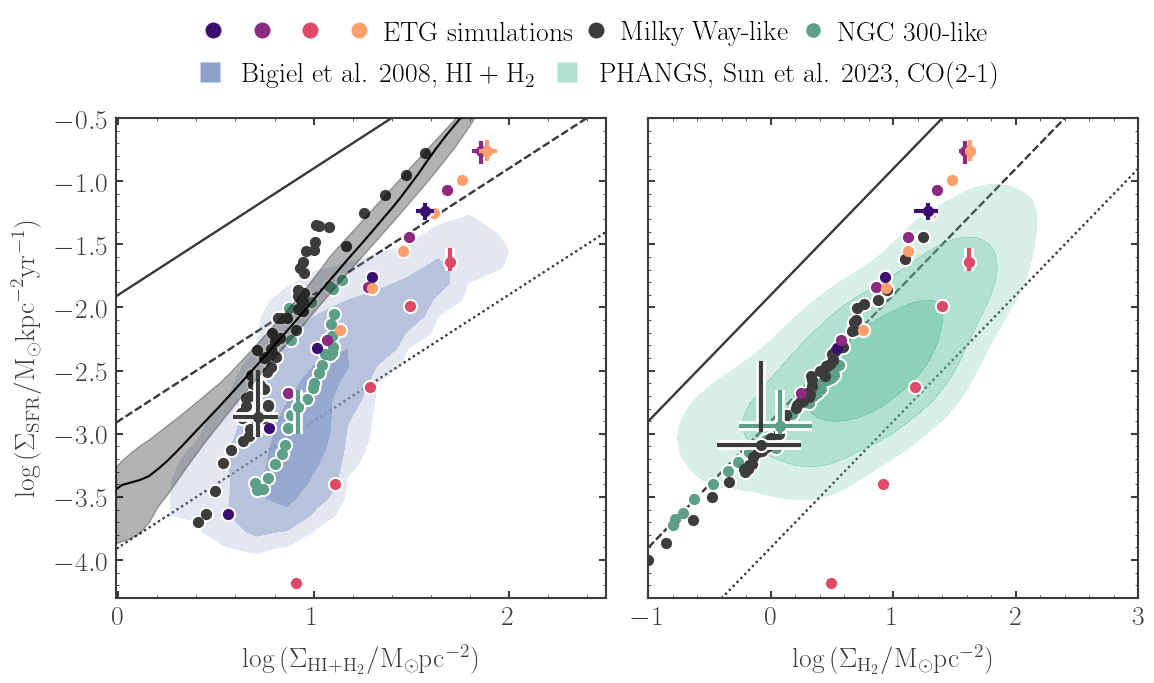

In [43]:
figW = 14
figH = 6
fig = plt.figure(figsize=(figW, figH))

topMarg = 0.1
leftMarg = 0.15
botMarg = 0.1
rightMarg = 0.15

wBetMarg = 0.03
hBetMarg = 0.01

crightMarg = 0.105
cW = 0.04
cBet = 0.02

h = (1.0-topMarg-botMarg)
w = (1.0-leftMarg-rightMarg)/2

### axes ###
ax0 = fig.add_axes([leftMarg, botMarg, w, h], ylim=[-4.3, -0.5], xlim=[-0.01, 2.5],
                  xlabel=r'$\log{(\Sigma_{\rm HI+H_2}/{\rm M}_\odot {\rm pc}^{-2})}$',
                  ylabel=r'$\log{(\Sigma_{\rm SFR}/{\rm M}_\odot {\rm kpc}^{-2}{\rm yr}^{-1})}$')
ax1 = fig.add_axes([leftMarg+w+wBetMarg, botMarg, w, h], ylim=[-4.3, -0.5], xlim=[-1., 2.5],
                  xlabel=r'$\log{(\Sigma_{\rm H_2}/{\rm M}_\odot {\rm pc}^{-2})}$',
                  ylabel=r'', yticklabels='')
axs = [ax0, ax1]

# plot stuff
# Bigiel08 data
ax0.contourf(denHIH2_normalized, [fHIH2(0.95), 1], linewidths=2., colors=[plt.cm.Set2(2)], linestyles='dotted',
                   extent=[xlim[0], xlim[1], ylim[0], ylim[1]], alpha=0.25)
ax0.contourf(denHIH2_normalized, [fHIH2(0.8), 1], linewidths=2., colors=[plt.cm.Set2(2)], linestyles='dashed',
                    extent=[xlim[0], xlim[1], ylim[0], ylim[1]], alpha=0.5)
ax0.contourf(denHIH2_normalized, [fHIH2(0.4), 1], linewidths=2., colors=[plt.cm.Set2(2)], linestyles='solid',
                    extent=[xlim[0], xlim[1], ylim[0], ylim[1]], alpha=0.75)

# lines of const. depl. time
xmin, xmax = -0.01, 3.5
x_plt = np.linspace(xmin, xmax, 100)
y_1e8 = x_plt-1.9
y_1e9 = x_plt-2.9
y_1e10 = x_plt-3.9

ax0.plot(x_plt, y_1e8, "-", color='#3C3C3C', zorder=0)
ax0.plot(x_plt, y_1e9, "--", color='#3C3C3C', zorder=0)
ax0.plot(x_plt, y_1e10, ":", color='#3C3C3C', zorder=0)
ax0.plot(x_plt, y_1e8, "-", label="$10^8$ yr", color='#3C3C3C', zorder=0)
ax0.plot(x_plt, y_1e9, "--", label="$10^9$ yr", color='#3C3C3C', zorder=0)
ax0.plot(x_plt, y_1e10, ":", label="$10^{10}$ yr", color='#3C3C3C', zorder=0)

# Line from SH03 (sample of 21 normal spirals from K98)
ax0.plot(logsurfdenses_SH03_bincentres, med_logSigmaSFR_SH03, color='k', zorder=5)
ax0.fill_between(logsurfdenses_SH03_bincentres, q1_logSigmaSFR_SH03, y2=q4_logSigmaSFR_SH03, alpha=0.3, color='k', zorder=5)

# NGC300
ax0.scatter(np.log10(NGC300medSigmag[0]/Msol_to_g*pc_to_cm**2), np.log10(NGC300medSigmaSFRs[0]), s=50, color='#5E9F87', zorder=3)
ax0.scatter(np.log10(NGC300medSigmag[0]/Msol_to_g*pc_to_cm**2), np.log10(NGC300medSigmaSFRs[0]), s=100, color='white', zorder=2)

# one error bar
ax0.scatter(np.log10(NGC300medSigmag[0][-10]/Msol_to_g*pc_to_cm**2), np.log10(NGC300medSigmaSFRs[0][-10]),
            s=50, color='#5E9F87', zorder=5)
ax0.scatter(np.log10(NGC300medSigmag[0][-10]/Msol_to_g*pc_to_cm**2), np.log10(NGC300medSigmaSFRs[0][-10]),
            s=100, color='white', zorder=4)
ax0.vlines(np.log10(NGC300medSigmag[0][-10]/Msol_to_g*pc_to_cm**2), np.log10(NGC300q1SigmaSFRs[0][-10]),
           ymax=np.log10(NGC300q4SigmaSFRs[0][-10]),
           lw=3, color='#5E9F87', zorder=5)
ax0.vlines(np.log10(NGC300medSigmag[0][-10]/Msol_to_g*pc_to_cm**2), np.log10(NGC300q1SigmaSFRs[0][-10]),
           ymax=np.log10(NGC300q4SigmaSFRs[0][-10]),
           lw=7, color='white', zorder=4)
ax0.hlines(np.log10(NGC300medSigmaSFRs[0][-10]), np.log10(NGC300q1Sigmag[0][-10]/Msol_to_g*pc_to_cm**2),
           xmax=np.log10(NGC300q4Sigmag[0][-10]/Msol_to_g*pc_to_cm**2),
           lw=3, color='#5E9F87', zorder=5)
ax0.hlines(np.log10(NGC300medSigmaSFRs[0][-10]), np.log10(NGC300q1Sigmag[0][-10]/Msol_to_g*pc_to_cm**2),
           xmax=np.log10(NGC300q4Sigmag[0][-10]/Msol_to_g*pc_to_cm**2),
           lw=7, color='white', zorder=4)

# MW
ax0.scatter(np.log10(MWmedSigmag[0]/Msol_to_g*pc_to_cm**2), np.log10(MWmedSigmaSFRs[0]),
            s=50, color='#3C3C3C', zorder=3)
ax0.scatter(np.log10(MWmedSigmag[0]/Msol_to_g*pc_to_cm**2), np.log10(MWmedSigmaSFRs[0]),
            s=100, color='white', zorder=2)

# one error bar
ax0.scatter(np.log10(MWmedSigmag[0][-10]/Msol_to_g*pc_to_cm**2), np.log10(MWmedSigmaSFRs[0][-10]),
            s=50, color='#3C3C3C', zorder=5)
ax0.scatter(np.log10(MWmedSigmag[0][-10]/Msol_to_g*pc_to_cm**2), np.log10(MWmedSigmaSFRs[0][-10]),
            s=100, color='white', zorder=4)
ax0.vlines(np.log10(MWmedSigmag[0][-10]/Msol_to_g*pc_to_cm**2), np.log10(MWq1SigmaSFRs[0][-10]),
           ymax=np.log10(MWq4SigmaSFRs[0][-10]),
           lw=3, color='#3C3C3C', zorder=5)
ax0.vlines(np.log10(MWmedSigmag[0][-10]/Msol_to_g*pc_to_cm**2), np.log10(MWq1SigmaSFRs[0][-10]),
           ymax=np.log10(MWq4SigmaSFRs[0][-10]),
           lw=7, color='white', zorder=4)
ax0.hlines(np.log10(MWmedSigmaSFRs[0][-10]), np.log10(MWq1Sigmag[0][-10]/Msol_to_g*pc_to_cm**2),
           xmax=np.log10(MWq4Sigmag[0][-10]/Msol_to_g*pc_to_cm**2),
           lw=3, color='#3C3C3C', zorder=5)
ax0.hlines(np.log10(MWmedSigmaSFRs[0][-10]), np.log10(MWq1Sigmag[0][-10]/Msol_to_g*pc_to_cm**2),
           xmax=np.log10(MWq4Sigmag[0][-10]/Msol_to_g*pc_to_cm**2),
           lw=7, color='white', zorder=4)

# ETGs
for i in range(4):
    ax0.scatter(np.log10(medSigmag[i]/Msol_to_g*pc_to_cm**2), np.log10(medSigmaSFRs[i]),
                s=50, color=plt.cm.magma(float(i+1)/5.), zorder=3)
    ax0.scatter(np.log10(medSigmag[i]/Msol_to_g*pc_to_cm**2), np.log10(medSigmaSFRs[i]),
                s=100, color='white', zorder=2)
    # one error bar
    ax0.scatter(np.log10(medSigmag[i][0]/Msol_to_g*pc_to_cm**2), np.log10(medSigmaSFRs[i][0]),
                s=50, color=plt.cm.magma(float(i+1)/5.), zorder=5)
    ax0.scatter(np.log10(medSigmag[i][0]/Msol_to_g*pc_to_cm**2), np.log10(medSigmaSFRs[i][0]),
                s=100, color='white', zorder=4)
    ax0.vlines(np.log10(medSigmag[i][0]/Msol_to_g*pc_to_cm**2), np.log10(q1SigmaSFRs[i][0]),
               ymax=np.log10(q4SigmaSFRs[i][0]),
               lw=3, color=plt.cm.magma(float(i+1)/5.), zorder=5)
    ax0.vlines(np.log10(medSigmag[i][0]/Msol_to_g*pc_to_cm**2), np.log10(q1SigmaSFRs[i][0]),
               ymax=np.log10(q4SigmaSFRs[i][0]),
               lw=7, color='white', zorder=4)
    ax0.hlines(np.log10(medSigmaSFRs[i][0]), np.log10(q1Sigmag[i][0]/Msol_to_g*pc_to_cm**2),
               xmax=np.log10(q4Sigmag[i][0]/Msol_to_g*pc_to_cm**2),
               lw=3, color=plt.cm.magma(float(i+1)/5.), zorder=5)
    ax0.hlines(np.log10(medSigmaSFRs[i][0]), np.log10(q1Sigmag[i][0]/Msol_to_g*pc_to_cm**2),
               xmax=np.log10(q4Sigmag[i][0]/Msol_to_g*pc_to_cm**2),
               lw=7, color='white', zorder=4)

# PHANGS
density_contours.density_contour(np.log10(J23['Sigma-mol-S20']), np.log10(J23['Sigma-SFR-HaW4recal']),
                                 xscale='linear', yscale='linear', ax=ax1, color=plt.cm.Set2(0),
                                 edgecolor='None',
                                 levels=(0.4, 0.8, 0.95), xlim=[-1., 3.], ylim=[-4.3, -0.5])
ax1.set_yticklabels('')
for ax in axs:
    ax.tick_params(axis = 'both', bottom = True, top = True, left = True, right = True,
                   which = 'both', direction='in')
    ax.minorticks_on()

# lines of const. depl. time
xmin, xmax = -1., 3.5
x_plt = np.linspace(xmin, xmax, 100)
y_1e8 = x_plt-1.9
y_1e9 = x_plt-2.9
y_1e10 = x_plt-3.9

ax1.plot(x_plt, y_1e8, "-", color='#3C3C3C', zorder=0)
ax1.plot(x_plt, y_1e9, "--", color='#3C3C3C', zorder=0)
ax1.plot(x_plt, y_1e10, ":", color='#3C3C3C', zorder=0)
ax1.plot(x_plt, y_1e8, "-", label="$10^8$ yr", color='#3C3C3C', zorder=0)
ax1.plot(x_plt, y_1e9, "--", label="$10^9$ yr", color='#3C3C3C', zorder=0)
ax1.plot(x_plt, y_1e10, ":", label="$10^{10}$ yr", color='#3C3C3C', zorder=0)

# NGC300
ax1.scatter(np.log10(NGC300medSigmaH2[0]*2./Msol_to_g*pc_to_cm**2), np.log10(NGC300medSigmaSFRsH2[0]), s=50, color='#5E9F87', zorder=3)
ax1.scatter(np.log10(NGC300medSigmaH2[0]*2./Msol_to_g*pc_to_cm**2), np.log10(NGC300medSigmaSFRsH2[0]), s=100, color='white', zorder=2)

# one error bar
ax1.scatter(np.log10(NGC300medSigmaH2[0][-10]*2./Msol_to_g*pc_to_cm**2), np.log10(NGC300medSigmaSFRsH2[0][-10]),
            s=50, color='#5E9F87', zorder=5)
ax1.scatter(np.log10(NGC300medSigmaH2[0][-10]*2./Msol_to_g*pc_to_cm**2), np.log10(NGC300medSigmaSFRsH2[0][-10]),
            s=100, color='white', zorder=4)
ax1.vlines(np.log10(NGC300medSigmaH2[0][-10]*2./Msol_to_g*pc_to_cm**2), np.log10(NGC300q1SigmaSFRsH2[0][-10]),
           ymax=np.log10(NGC300q4SigmaSFRsH2[0][-10]),
           lw=3, color='#5E9F87', zorder=5)
ax1.vlines(np.log10(NGC300medSigmaH2[0][-10]*2./Msol_to_g*pc_to_cm**2), np.log10(NGC300q1SigmaSFRsH2[0][-10]),
           ymax=np.log10(NGC300q4SigmaSFRsH2[0][-10]),
           lw=7, color='white', zorder=4)
ax1.hlines(np.log10(NGC300medSigmaSFRsH2[0][-10]), np.log10(NGC300q1SigmaH2[0][-10]*2./Msol_to_g*pc_to_cm**2),
           xmax=np.log10(NGC300q4SigmaH2[0][-10]*2./Msol_to_g*pc_to_cm**2),
           lw=3, color='#5E9F87', zorder=5)
ax1.hlines(np.log10(NGC300medSigmaSFRsH2[0][-10]), np.log10(NGC300q1SigmaH2[0][-10]*2./Msol_to_g*pc_to_cm**2),
           xmax=np.log10(NGC300q4SigmaH2[0][-10]*2./Msol_to_g*pc_to_cm**2),
           lw=7, color='white', zorder=4)

# MW
ax1.scatter(np.log10(MWmedSigmaH2[0][2:]*2./Msol_to_g*pc_to_cm**2), np.log10(MWmedSigmaSFRsH2[0][2:]),
            s=50, color='#3C3C3C', zorder=3)
ax1.scatter(np.log10(MWmedSigmaH2[0][2:]*2./Msol_to_g*pc_to_cm**2), np.log10(MWmedSigmaSFRsH2[0][2:]),
            s=100, color='white', zorder=2)

# one error bar
ax1.scatter(np.log10(MWmedSigmaH2[0][-10]*2./Msol_to_g*pc_to_cm**2), np.log10(MWmedSigmaSFRsH2[0][-10]),
            s=50, color='#3C3C3C', zorder=5)
ax1.scatter(np.log10(MWmedSigmaH2[0][-10]*2./Msol_to_g*pc_to_cm**2), np.log10(MWmedSigmaSFRsH2[0][-10]),
            s=100, color='white', zorder=4)
ax1.vlines(np.log10(MWmedSigmaH2[0][-10]*2./Msol_to_g*pc_to_cm**2), np.log10(MWq1SigmaSFRsH2[0][-10]),
           ymax=np.log10(MWq4SigmaSFRsH2[0][-10]),
           lw=3, color='#3C3C3C', zorder=5)
ax1.vlines(np.log10(MWmedSigmaH2[0][-10]*2./Msol_to_g*pc_to_cm**2), np.log10(MWq1SigmaSFRsH2[0][-10]),
           ymax=np.log10(MWq4SigmaSFRsH2[0][-10]),
           lw=7, color='white', zorder=4)
ax1.hlines(np.log10(MWmedSigmaSFRsH2[0][-10]), np.log10(MWq1SigmaH2[0][-10]*2./Msol_to_g*pc_to_cm**2),
           xmax=np.log10(MWq4SigmaH2[0][-10]*2./Msol_to_g*pc_to_cm**2),
           lw=3, color='#3C3C3C', zorder=5)
ax1.hlines(np.log10(MWmedSigmaSFRsH2[0][-10]), np.log10(MWq1SigmaH2[0][-10]*2./Msol_to_g*pc_to_cm**2),
           xmax=np.log10(MWq4SigmaH2[0][-10]*2./Msol_to_g*pc_to_cm**2),
           lw=7, color='white', zorder=4)

# ETGs
for i in range(4):
    ax1.scatter(np.log10(medSigmaH2[i]/Msol_to_g*pc_to_cm**2), np.log10(medSigmaSFRs[i]),
                s=50, color=plt.cm.magma(float(i+1)/5.), zorder=3)
    ax1.scatter(np.log10(medSigmaH2[i]/Msol_to_g*pc_to_cm**2), np.log10(medSigmaSFRs[i]),
                s=100, color='white', zorder=2)
    
    # one error bar
    ax1.scatter(np.log10(medSigmaH2[i][0]/Msol_to_g*pc_to_cm**2), np.log10(medSigmaSFRs[i][0]),
                s=50, color=plt.cm.magma(float(i+1)/5.), zorder=5)
    ax1.scatter(np.log10(medSigmaH2[i][0]/Msol_to_g*pc_to_cm**2), np.log10(medSigmaSFRs[i][0]),
                s=100, color='white', zorder=4)
    ax1.vlines(np.log10(medSigmaH2[i][0]/Msol_to_g*pc_to_cm**2), np.log10(q1SigmaSFRs[i][0]),
               ymax=np.log10(q4SigmaSFRs[i][0]),
               lw=3, color=plt.cm.magma(float(i+1)/5.), zorder=5)
    ax1.vlines(np.log10(medSigmaH2[i][0]/Msol_to_g*pc_to_cm**2), np.log10(q1SigmaSFRs[i][0]),
               ymax=np.log10(q4SigmaSFRs[i][0]),
               lw=7, color='white', zorder=4)
    ax1.hlines(np.log10(medSigmaSFRs[i][0]), np.log10(q1SigmaH2[i][0]/Msol_to_g*pc_to_cm**2),
               xmax=np.log10(q4SigmaH2[i][0]/Msol_to_g*pc_to_cm**2),
               lw=3, color=plt.cm.magma(float(i+1)/5.), zorder=5)
    ax1.hlines(np.log10(medSigmaSFRs[i][0]), np.log10(q1SigmaH2[i][0]/Msol_to_g*pc_to_cm**2),
               xmax=np.log10(q4SigmaH2[i][0]/Msol_to_g*pc_to_cm**2),
               lw=7, color='white', zorder=4)

# legend, data
custom_lines = [Line2D([0], [0], marker='s', markeredgecolor='None', markerfacecolor=plt.cm.Set2(2),
                       markersize=15, lw=0),
                Line2D([0], [0], marker='s', markeredgecolor='None', markerfacecolor=plt.cm.Set2(0),
                       markersize=15, alpha=0.5, lw=0)]
legend1 = ax1.legend(
    custom_lines, [r'Bigiel et al. 2008, ${\rm HI+H_2}$', 'PHANGS, Sun et al. 2023, CO(2-1)'],
    loc='lower center', bbox_to_anchor=(-0.1, 1.01), ncol=2, frameon=False, handlelength=0.75, columnspacing=0.75
)

# legend, sims
custom_lines = [Line2D([0], [0], marker='o', markerfacecolor=plt.cm.magma(1./5.),
                       markeredgecolor='white', markersize=12.5, lw=0),
                Line2D([0], [0], marker='o', markerfacecolor=plt.cm.magma(2./5.),
                       markeredgecolor='white', markersize=12.5, lw=0),
                Line2D([0], [0], marker='o', markerfacecolor=plt.cm.magma(3./5.),
                       markeredgecolor='white', markersize=12.5, lw=0),
                Line2D([0], [0], marker='o', markerfacecolor=plt.cm.magma(4./5.),
                       markeredgecolor='white', markersize=12.5, lw=0),
                Line2D([0], [0], marker='o', markerfacecolor='#3C3C3C',
                       markeredgecolor='white', markersize=12.5, lw=0),
                Line2D([0], [0], marker='o', markerfacecolor='#5E9F87', markeredgewidth=2,
                       markeredgecolor='white', markersize=12.5, lw=3)]
legend2 = ax1.legend(
    custom_lines, [r'', r'', r'', r'ETG simulations', r'Milky Way-like', r'NGC~300-like'],
    loc='lower center', bbox_to_anchor=(-0.1, 1.1), ncol=6, frameon=False, handlelength=0.2, columnspacing=0.75
)
ax1.add_artist(legend1)
#ax1.add_artist(legend2)

plt.savefig(
    '/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/figs/obs-comparison-Sigmagas.pdf',
    bbox_inches='tight',
    format='pdf'
)
    
plt.show()

# black background

In [44]:
# # Plotting properties
# from matplotlib import rc
# mpl.rcParams['text.usetex'] = True
# mpl.rcParams['font.family'] = 'serif'
# mpl.rcParams['font.weight'] = 'normal'
# mpl.rcParams['xtick.major.pad'] = 5
# mpl.rcParams['ytick.major.pad'] = 5
# mpl.rcParams['axes.labelpad'] = 10
# mpl.rcParams['font.size'] = 20
# mpl.rcParams['legend.fontsize'] = 20
# mpl.rcParams['legend.numpoints'] = 1
# mpl.rcParams['savefig.dpi'] = 100
# mpl.rcParams['mathtext.default'] = 'regular'
# plt.rcParams['figure.facecolor'] = 'black'
# mpl.rcParams['text.color'] = 'white'
# mpl.rcParams['axes.labelcolor'] = 'white'
# mpl.rcParams['axes.facecolor'] = 'black'
# mpl.rcParams['axes.edgecolor'] = 'white'
# mpl.rcParams['xtick.color'] = 'white'
# mpl.rcParams['ytick.color'] = 'white'
# labels_font = {'size':'20'}

# cmap = plt.cm.pink
# cmap.set_bad('black')

In [45]:
# figW = 17
# figH = 9
# fig = plt.figure(figsize=(figW, figH))

# botMarg = 0.1
# wBetMarg = 0.007
# topMarg = 0.02
# leftMarg = 0.1
# hBetMarg = 0.01

# crightMarg = 0.105
# cW = 0.015
# cBet = 0.002
# rightMarg = 0.03 + crightMarg + cW

# h = (1.0-topMarg-3.*hBetMarg-botMarg)/10.
# w = (1.0-leftMarg-4.*wBetMarg-rightMarg)/4.

# ### axes ###
# # total gas
# axf0 = fig.add_axes([leftMarg, botMarg+6*h+3*hBetMarg, w, 4*h],
#                  xlabel='', ylabel='', xticklabels='', yticklabels='')
# axf1 = fig.add_axes([leftMarg+w+wBetMarg, botMarg+6*h+3*hBetMarg, w, 4*h],
#                  xlabel='', ylabel='', xticklabels='', yticklabels='')
# axf2 = fig.add_axes([leftMarg+2*(w+wBetMarg), botMarg+6*h+3*hBetMarg, w, 4*h],
#                  xlabel='', ylabel='', xticklabels='', yticklabels='')
# axf3 = fig.add_axes([leftMarg+3*(w+wBetMarg), botMarg+6*h+3*hBetMarg, w, 4*h],
#                  xlabel='', ylabel='', xticklabels='', yticklabels='')
# axsf = [axf0, axf1, axf2, axf3]
# for ax, label in zip(axsf, labels):
#     ax.set_title(label, fontsize=20)

# axe0 = fig.add_axes([leftMarg, botMarg+5*h+2*hBetMarg, w, h],
#                  xlabel='', ylabel='', xticklabels='', yticklabels='')
# axe1 = fig.add_axes([leftMarg+w+wBetMarg, botMarg+5*h+2*hBetMarg, w, h],
#                  xlabel='', ylabel='', xticklabels='', yticklabels='')
# axe2 = fig.add_axes([leftMarg+2*(w+wBetMarg), botMarg+5*h+2*hBetMarg, w, h],
#                  xlabel='', ylabel='', xticklabels='', yticklabels='')
# axe3 = fig.add_axes([leftMarg+3*(w+wBetMarg), botMarg+5*h+2*hBetMarg, w, h],
#                  xlabel='', ylabel='', xticklabels='', yticklabels='')
# axse = [axe0, axe1, axe2, axe3]
# cax = fig.add_axes([leftMarg+4*w+4.*wBetMarg+cBet, botMarg+5*h+2*hBetMarg, cW, 5*h+hBetMarg])

# # molecular gas
# ax1f0 = fig.add_axes([leftMarg, botMarg+h+hBetMarg, w, 4*h],
#                  xlabel='', ylabel='', xticklabels='', yticklabels='')
# ax1f1 = fig.add_axes([leftMarg+w+wBetMarg, botMarg+h+hBetMarg, w, 4*h],
#                  xlabel='', ylabel='', xticklabels='', yticklabels='')
# ax1f2 = fig.add_axes([leftMarg+2*(w+wBetMarg), botMarg+h+hBetMarg, w, 4*h],
#                  xlabel='', ylabel='', xticklabels='', yticklabels='')
# ax1f3 = fig.add_axes([leftMarg+3*(w+wBetMarg), botMarg+h+hBetMarg, w, 4*h],
#                  xlabel='', ylabel='', xticklabels='', yticklabels='')
# axs1f = [ax1f0, ax1f1, ax1f2, ax1f3]
# ax1e0 = fig.add_axes([leftMarg, botMarg, w, h],
#                  xlabel='', ylabel='', xticklabels='', yticklabels='')
# ax1e1 = fig.add_axes([leftMarg+w+wBetMarg, botMarg, w, h],
#                  xlabel='', ylabel='', xticklabels='', yticklabels='')
# ax1e2 = fig.add_axes([leftMarg+2*(w+wBetMarg), botMarg, w, h],
#                  xlabel='', ylabel='', xticklabels='', yticklabels='')
# ax1e3 = fig.add_axes([leftMarg+3*(w+wBetMarg), botMarg, w, h],
#                  xlabel='', ylabel='', xticklabels='', yticklabels='')
# axs1e = [ax1e0, ax1e1, ax1e2, ax1e3]
# cax1 = fig.add_axes([leftMarg+4*w+4.*wBetMarg+cBet, botMarg, cW, 5*h+hBetMarg])

# ### plot maps on axes ###
# # total gas
# for ax, img in zip(axsf, imgsf):
#     ax.tick_params(axis='both', which='both', length=0)
#     mapgf = ax.imshow(
#         img*1.e10/(1.e3)**2, cmap=plt.cm.pink, norm=LogNorm(),
#         vmin = 1., vmax = 1000.,
#         aspect='auto', extent=[-width_kpc/2., width_kpc/2., -width_kpc/2., width_kpc/2.],
#     )
    
# for ax, img in zip(axse, imgse):
#     ax.tick_params(axis='both', which='both', length=0)
#     mapge = ax.imshow(
#         img*1.e10/(1.e3)**2, cmap=plt.cm.pink, norm=LogNorm(),
#         vmin = 1., vmax = 1000.,
#         aspect='auto', extent=[-width_kpc/2., width_kpc/2., -width_kpc/4., width_kpc/4.],
#     )
    
# # molecular gas
# for ax, img, LCOimg in zip(axs1f, imgsf, LCOimgsf):
#     ax.tick_params(axis='both', which='both', length=0)
#     pltimg = img*LCOimg*2.8e28*1.e10/(1.e3)**2
#     mapgf1 = ax.imshow(
#         pltimg, cmap=plt.cm.terrain, norm=LogNorm(),
#         vmin = 1., vmax = 999.,
#         aspect='auto', extent=[-width_kpc/2., width_kpc/2., -width_kpc/2., width_kpc/2.],
#     )
    
# for ax, img, LCOimg in zip(axs1e, imgse, LCOimgse):
#     ax.tick_params(axis='both', which='both', length=0)
#     pltimg = img*LCOimg*2.8e28*1.e10/(1.e3)**2
#     mapge1 = ax.imshow(
#         pltimg, cmap=plt.cm.terrain, norm=LogNorm(),
#         vmin = 1., vmax = 999.,
#         aspect='auto', extent=[-width_kpc/2., width_kpc/2., -width_kpc/4., width_kpc/4.],
#     )
    

# # ### colorbars ###
# cbar = fig.colorbar(mapgf, cax=cax)
# cbar.set_label(r'$\Sigma_{\rm g}/{\rm M}_\odot {\rm pc}^{-2}$')
# cax.tick_params(axis='both', direction='in', top=True, bottom=False)

# cbar1 = fig.colorbar(mapgf1, cax=cax1)
# cbar1.set_label(r'$\Sigma_{\rm H_2}/{\rm M}_\odot {\rm pc}^{-2}$')
# cax1.tick_params(axis='both', direction='in', top=True, bottom=False)
    
# ### scale-bars ###
# scalebar = AnchoredSizeBar(
#     axf0.transData, 1, '1 kpc', 'lower left',
#     color='white', frameon=False, size_vertical=0.05, pad=1., sep=10,
#     fontproperties=fontprops
# )

# axf0.add_artist(scalebar)

# plt.savefig(
#     '/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/figs/morphology-bb.pdf', facecolor='k',
#     bbox_inches='tight',
#     format='pdf'
# )

# plt.show()